**An Unsupervised Approach to Classify Astronomical Objects**

Group members: Alexa Schor, Carlos Herbozo, Yee Xian Siow

# Library imports and configuration

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import itertools
import math
import imblearn.over_sampling as ios
import imblearn.under_sampling as ius
import imblearn.combine as icb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [ ]:
matplotlib.rc('font', family='monospace')
matplotlib.rc('text', usetex='false')

# Load and divide data

In [ ]:
!rm -f sdss_dr12_objects.csv
!wget -q ftp://ftp.astro.yale.edu/pub/aghosh/phys_378_projects/unsup_class/sdss_dr12_objects.csv
!tail -n +2 sdss_dr12_objects.csv > objects.csv
!du -h objects.csv
!shasum objects.csv | awk '$1=="9473e3915e0c4fce4d5a270c9e3382f1959e28e7"{print "Checksum verified"}'

3.9M	objects.csv
Checksum verified


In [ ]:
# Load data
raw_df = pd.read_csv('objects.csv')

# only keep the columns we need
df = raw_df.drop(['objid', 'ra', 'dec', 'specobjid'], axis=1)

categories = {"GALAXY": 0, "STAR": 1, "QSO": 2}

df["class"] = df["class"].replace("GALAXY", 0)
df["class"] = df["class"].replace("STAR",   1)
df["class"] = df["class"].replace("QSO",    2)

df.head()

u         g         r         i         z  class  redshift
0  16.32475  15.41002  15.00167  14.84394  14.72891      0  0.006298
1  17.77235  16.60964  16.73945  16.84984  16.95081      1  0.000047
2  19.13368  17.17648  16.12352  15.66259  15.27726      0  0.111066
3  18.75010  16.81842  15.94924  15.53820  15.21549      0  0.048963
4  18.94942  17.55173  16.97975  16.63628  16.44447      0  0.048947

The project description specifies the size of our testing and training data, and we'll chop off about 20% of our training data to use as valdation data.

In [ ]:
# Split into testing and training
training   = df[:18000]
validation = df[18000:22000]
testing    = df[22000:]

# Separate into data and label
t_data  = training.drop(["class"], axis=1)
t_label = training["class"]

v_data  = validation.drop(["class"], axis=1)
v_label = validation["class"]

T_data  = testing.drop(["class"], axis=1)
T_label = testing["class"]

# Initial inspection

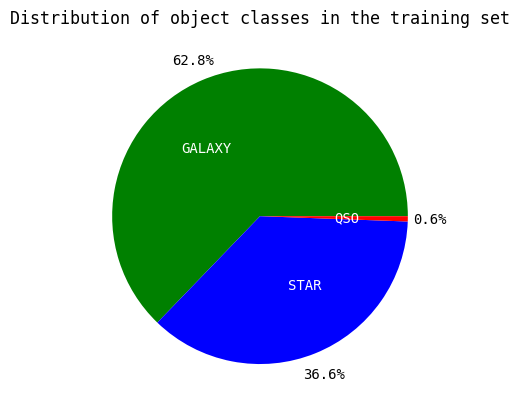

In [ ]:
# Visualize the distribution of classes
_, ls, _ = plt.pie(training['class'].value_counts().sort_index(),
                   labels=["GALAXY", "STAR", "QSO"], colors=("green", "blue", "red"),
                   shadow = False, autopct='%1.1f%%', pctdistance=1.15, labeldistance=0.5)
for l in ls:
  l.set_color("white")
plt.title("Distribution of object classes in the training set")
plt.show()

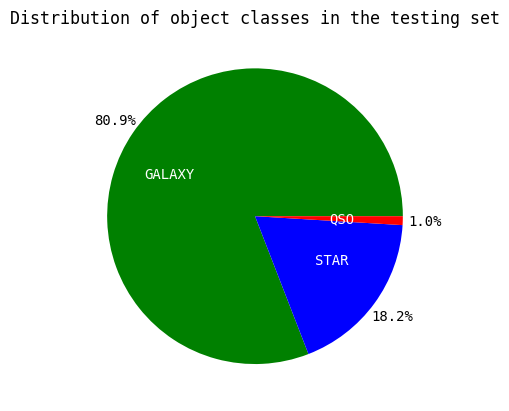

In [ ]:
# Visualize the distribution of classes
_, ls, _ = plt.pie(testing['class'].value_counts().sort_index(),
                   labels=["GALAXY", "STAR", "QSO"], colors=("green", "blue", "red"),
                   shadow = False, autopct='%1.1f%%', pctdistance=1.15, labeldistance=0.5)
for l in ls:
  l.set_color("white")
plt.title("Distribution of object classes in the testing set")
plt.show()

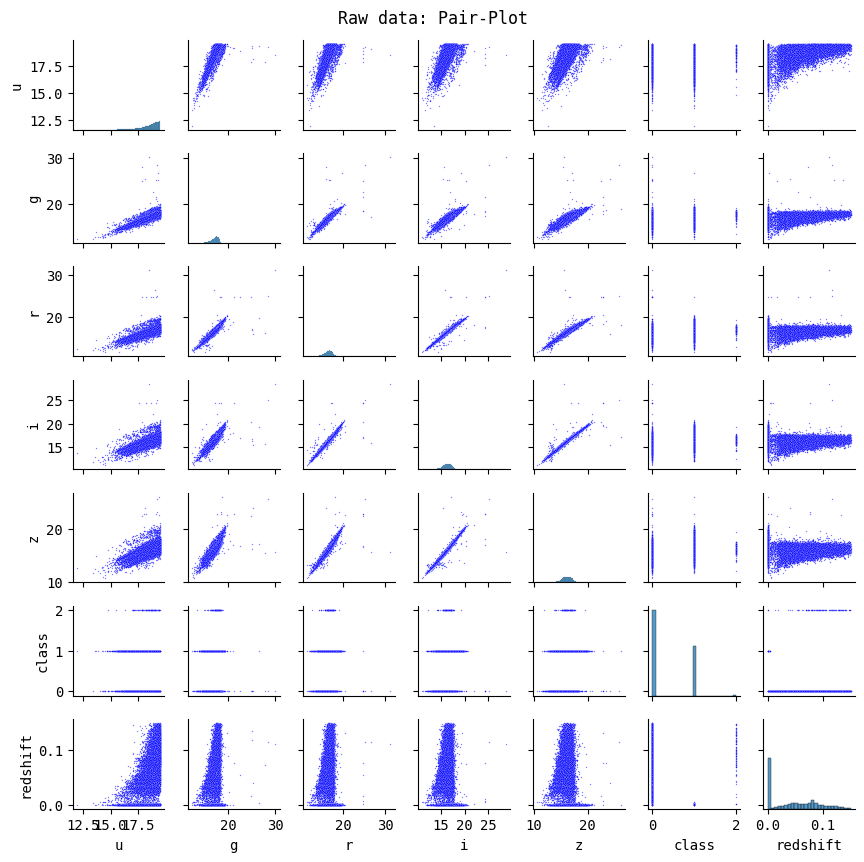

In [ ]:
pp = sns.pairplot(training, height=1.25, plot_kws={"s": 1, "alpha": 0.5, "color": "blue"})
pp.fig.suptitle("Raw data: Pair-Plot")
pp.fig.tight_layout()
pp.fig.show()

It is important to analyse if we have spatial differentiation of the object classes in the high-dimensional input space, because if this differentiation exists we will be able to use a spatial clustering scheme such as K-means or DBSCAN. If not, we may need to apply a different sort of learning method to classify our data. First let's analyze this layout under the input coordinate system.

# Clustering analysis

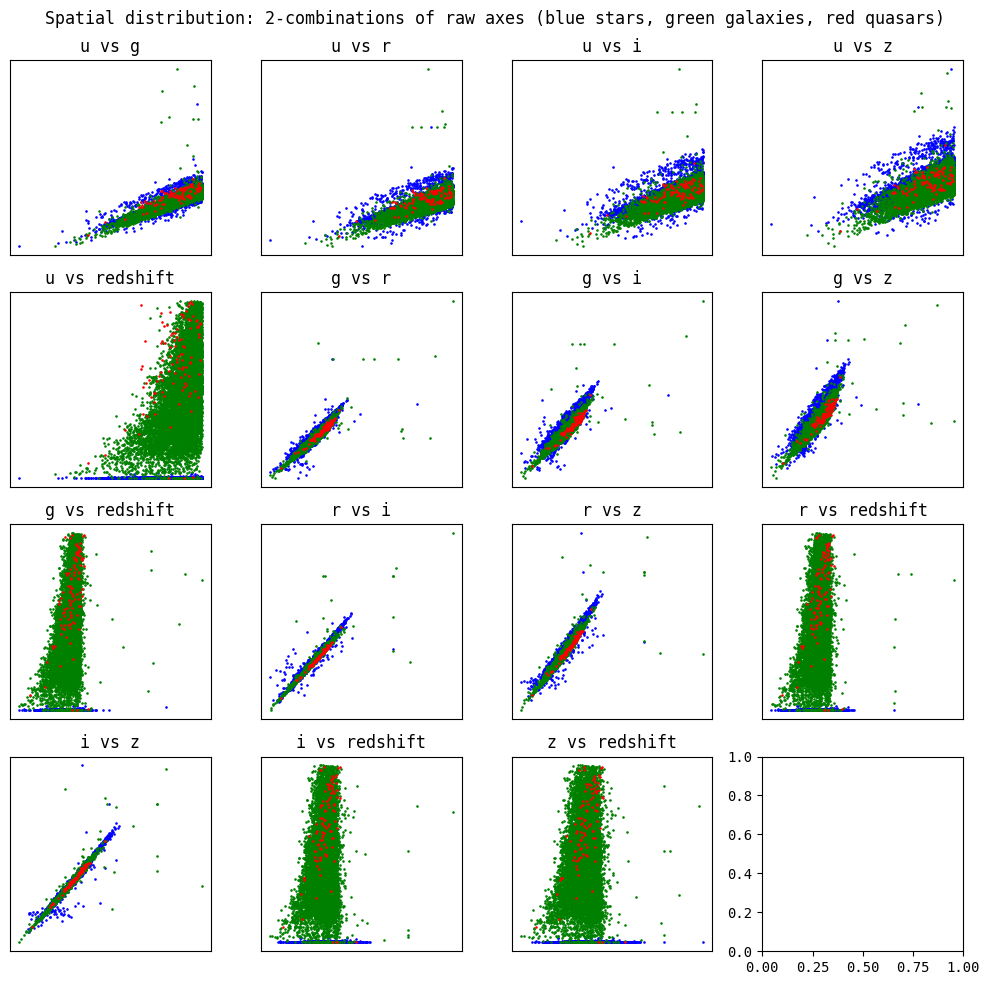

In [ ]:
cols = t_data.columns

views   = list(itertools.combinations(cols, 2))
width   = math.ceil(math.sqrt(len(views)))
height  = math.ceil(len(views)/width)
fig, axs = plt.subplots(width, height, figsize=(width*2.5, height*2.5))
axs = axs.flatten()

fig.suptitle("Spatial distribution: 2-combinations of raw axes (blue stars, green galaxies, red quasars)")

for (p1, p2), ax in zip(views, axs):
  ax.set_title(f"{p1} vs {p2}")

  ax.scatter(t_data[p1][t_label==1], t_data[p2][t_label==1], color="blue",  s=0.75, alpha=1, label="Star")
  ax.scatter(t_data[p1][t_label==0], t_data[p2][t_label==0], color="green", s=0.75, alpha=1, label="Galaxy")
  ax.scatter(t_data[p1][t_label==2], t_data[p2][t_label==2], color="red",   s=0.75, alpha=1, label="Quasar")

  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)

  fig.tight_layout()
  fig.show()

At initial investigation, a few properties are visible. The first is that our classes are not equally represented in the dataset. Of the objects present, the majority are galaxies, and quasars are severely underrepresented in the dataset. We may have to compensate for this class imbalance if it creates problems later. The second property is that, examining the pairplots of class with each other variable in our dataset, it doesn't seem like we have any "magic bullet" variable or small set of variables which will directly identify our class, at least in this coordinate system.

# Data balancing

Because of the class imbalance we noted in our data, we'll apply an evening operation to our training data via a combination of Tomek link undersampling and ADASYN oversampling:

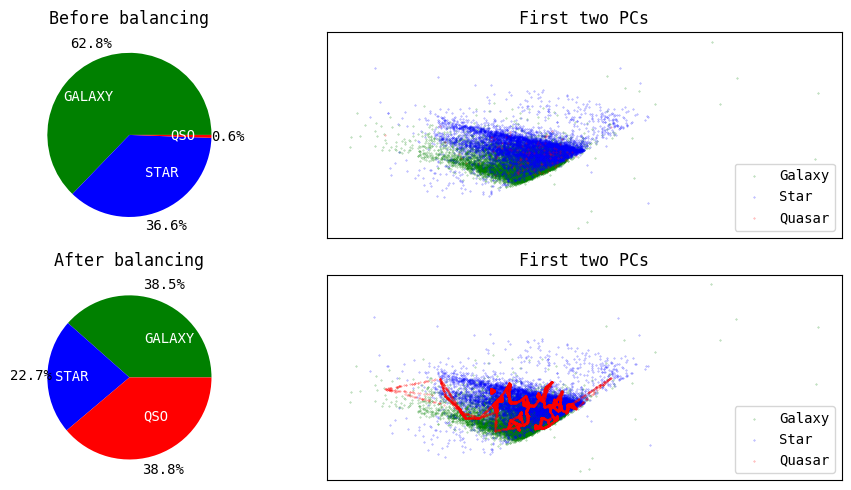

In [ ]:
oversam  = ios.SMOTE      (sampling_strategy='minority', k_neighbors=3)
undersam = ius.TomekLinks (sampling_strategy='not minority')
balancer = icb.SMOTETomek (sampling_strategy='all', smote=oversam, tomek=undersam)
tb_data, tb_label = balancer.fit_resample(t_data, t_label)

fig, axss = plt.subplots(2, 2, figsize=(10,5))

for (data, label), title, axs in zip( [(t_data, t_label), (tb_data, tb_label)],
                                      ["Before balancing", "After balancing"],
                                      axss ):
  # Plot pie chart
  _, ls, _ = axs[0].pie( label.value_counts().sort_index(),
                         labels=["GALAXY", "STAR", "QSO"],
                         colors=("green", "blue", "red"),
                         autopct='%1.1f%%',
                         pctdistance=1.2,
                         labeldistance=0.5 )

  axs[0].set_title(title)
  for l in ls:
    l.set_color("white")

  # Vis PCA
  pca = PCA(n_components=2)
  df_pca = pd.DataFrame(pca.fit_transform(data), columns=['PC1', 'PC2'])

  axs[1].set_title('First two PCs')

  axs[1].scatter(df_pca['PC1'][label==0], df_pca['PC2'][label==0], color="green", s=0.1, alpha=0.5, label="Galaxy")
  axs[1].scatter(df_pca['PC1'][label==1], df_pca['PC2'][label==1], color="blue",  s=0.1, alpha=0.5, label="Star")
  axs[1].scatter(df_pca['PC1'][label==2], df_pca['PC2'][label==2], color="red",   s=0.1, alpha=0.5,   label="Quasar")

  axs[1].axes.xaxis.set_visible(False)
  axs[1].axes.yaxis.set_visible(False)
  axs[1].legend()

fig.tight_layout()
fig.show()

In order to examine further the spatial distribution of the classes in our data points, we will perform some class-aware analysis to obtain a subspace that is useful for visualization of the different clusters.

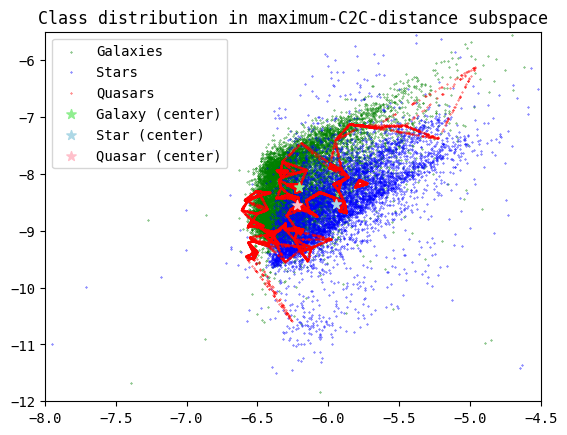

In [ ]:
galaxies = tb_data[tb_label==0]
stars    = tb_data[tb_label==1]
quasars  = tb_data[tb_label==2]


g_cnt = np.mean(galaxies, axis=0)
s_cnt = np.mean(stars,    axis=0)
q_cnt = np.mean(quasars,  axis=0)

v1 = (s_cnt - q_cnt)
v2 = (g_cnt - q_cnt)

a1 = v1
a2 = v2

g_sub_x = [np.dot(v, a1) for _, v in galaxies.iterrows()]
g_sub_y = [np.dot(v, a2) for _, v in galaxies.iterrows()]

s_sub_x = [np.dot(v, a1) for _, v in stars.iterrows()]
s_sub_y = [np.dot(v, a2) for _, v in stars.iterrows()]

q_sub_x = [np.dot(v, a1) for _, v in quasars.iterrows()]
q_sub_y = [np.dot(v, a2) for _, v in quasars.iterrows()]

gc_sub = [np.dot(g_cnt, a1), np.dot(g_cnt, a2)]
sc_sub = [np.dot(s_cnt, a1), np.dot(s_cnt, a2)]
qc_sub = [np.dot(q_cnt, a1), np.dot(q_cnt, a2)]

plt.scatter(g_sub_x, g_sub_y, color="green", s=0.1, label="Galaxies")

plt.scatter(s_sub_x, s_sub_y, color="blue", s=0.1, label="Stars")

plt.scatter(q_sub_x, q_sub_y, color="red", s=0.1, label="Quasars")

plt.scatter([gc_sub[0]], [gc_sub[1]], color="lightgreen", s=50, marker="*", label="Galaxy (center)")
plt.scatter([sc_sub[0]], [sc_sub[1]], color="lightblue", s=50, marker="*", label="Star (center)")
plt.scatter([qc_sub[0]], [qc_sub[1]], color="pink", s=50, marker="*", label="Quasar (center)")

plt.xlim((-8,-4.5))
plt.ylim((-12,-5.5))


plt.title("Class distribution in maximum-C2C-distance subspace")


plt.legend();

# PCA Visualization

Given that we don't see any obvious spatial differentiation under our source axes, let's apply a PCA transform and visualize under those axes.

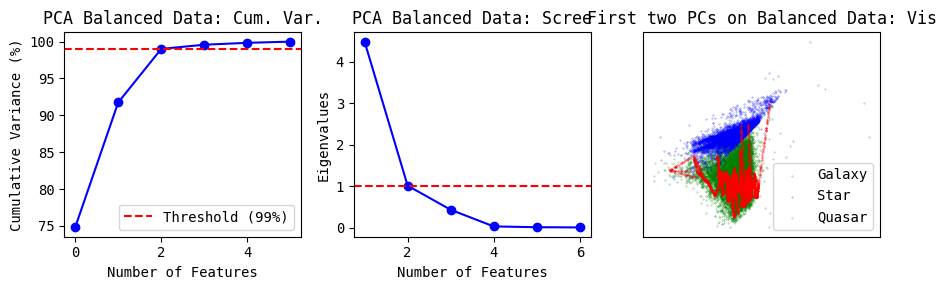

In [ ]:
# Scale both balanced and unbalanced values
data_scaler = StandardScaler().fit(tb_data)

tbs_data = pd.DataFrame(data_scaler.transform(tb_data), columns=tb_data.columns)
tbs_label = tb_label.copy()

# Also scale unbalanced, validation and testing with same scaler
ts_data = pd.DataFrame(data_scaler.transform(t_data), columns=t_data.columns)
vs_data = pd.DataFrame(data_scaler.transform(v_data), columns=v_data.columns)
Ts_data = pd.DataFrame(data_scaler.transform(T_data), columns=T_data.columns)

# Run PCA
pca = PCA()
pca.fit(tbs_data)

fig, axs = plt.subplots(1, 3, figsize=(9,3))
axs = axs.flatten()

# Plot cumulative variance and threshold
threshold_percentage = 99
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
axs[0].plot(cumulative_variance, marker='o', linestyle='-', color='b')
axs[0].axhline(y=threshold_percentage, color='r', linestyle='--', label=f'Threshold ({threshold_percentage}%)')
axs[0].set_title('PCA Balanced Data: Cum. Var.')
axs[0].set_xlabel('Number of Features')
axs[0].set_ylabel('Cumulative Variance (%)')
axs[0].legend()

# Scree Plot to determine the number of features based on eigenvalues
eigenvalues = pca.explained_variance_
axs[1].plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='b')
axs[1].axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1')
axs[1].set_title('PCA Balanced Data: Scree')
axs[1].set_xlabel('Number of Features')
axs[1].set_ylabel('Eigenvalues')

# Plot PCA visualization
pca = PCA(n_components=6)
tbs_pca_data = pd.DataFrame(pca.fit_transform(tbs_data), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
ts_pca_data = pd.DataFrame(pca.fit_transform(ts_data), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

axs[2].set_title('First two PCs on Balanced Data: Vis')

axs[2].scatter(tbs_pca_data['PC1'][tbs_label==0], tbs_pca_data['PC2'][tbs_label==0], color="green", s=0.1, alpha=0.5, label="Galaxy")
axs[2].scatter(tbs_pca_data['PC1'][tbs_label==1], tbs_pca_data['PC2'][tbs_label==1], color="blue",  s=0.1, alpha=0.5, label="Star")
axs[2].scatter(tbs_pca_data['PC1'][tbs_label==2], tbs_pca_data['PC2'][tbs_label==2], color="red",   s=0.1, alpha=0.5,   label="Quasar")

# axs[2].set_xlabel('PC1')
# axs[2].set_ylabel('PC2')
axs[2].axes.xaxis.set_visible(False)
axs[2].axes.yaxis.set_visible(False)
axs[2].legend()

fig.tight_layout()
fig.show()

The axes initially obtained via PCA explain a great deal of the variance of the dataset, and we can see that galaxies and stars lie in relatively distinct spatial clusters. However, under these components we can't see much spatial differentiation of quasars from other object classes. If there truely is none, this would be problematic for a spatial clustering approach. It could, however, just be due to our selection of subspace via PCA.

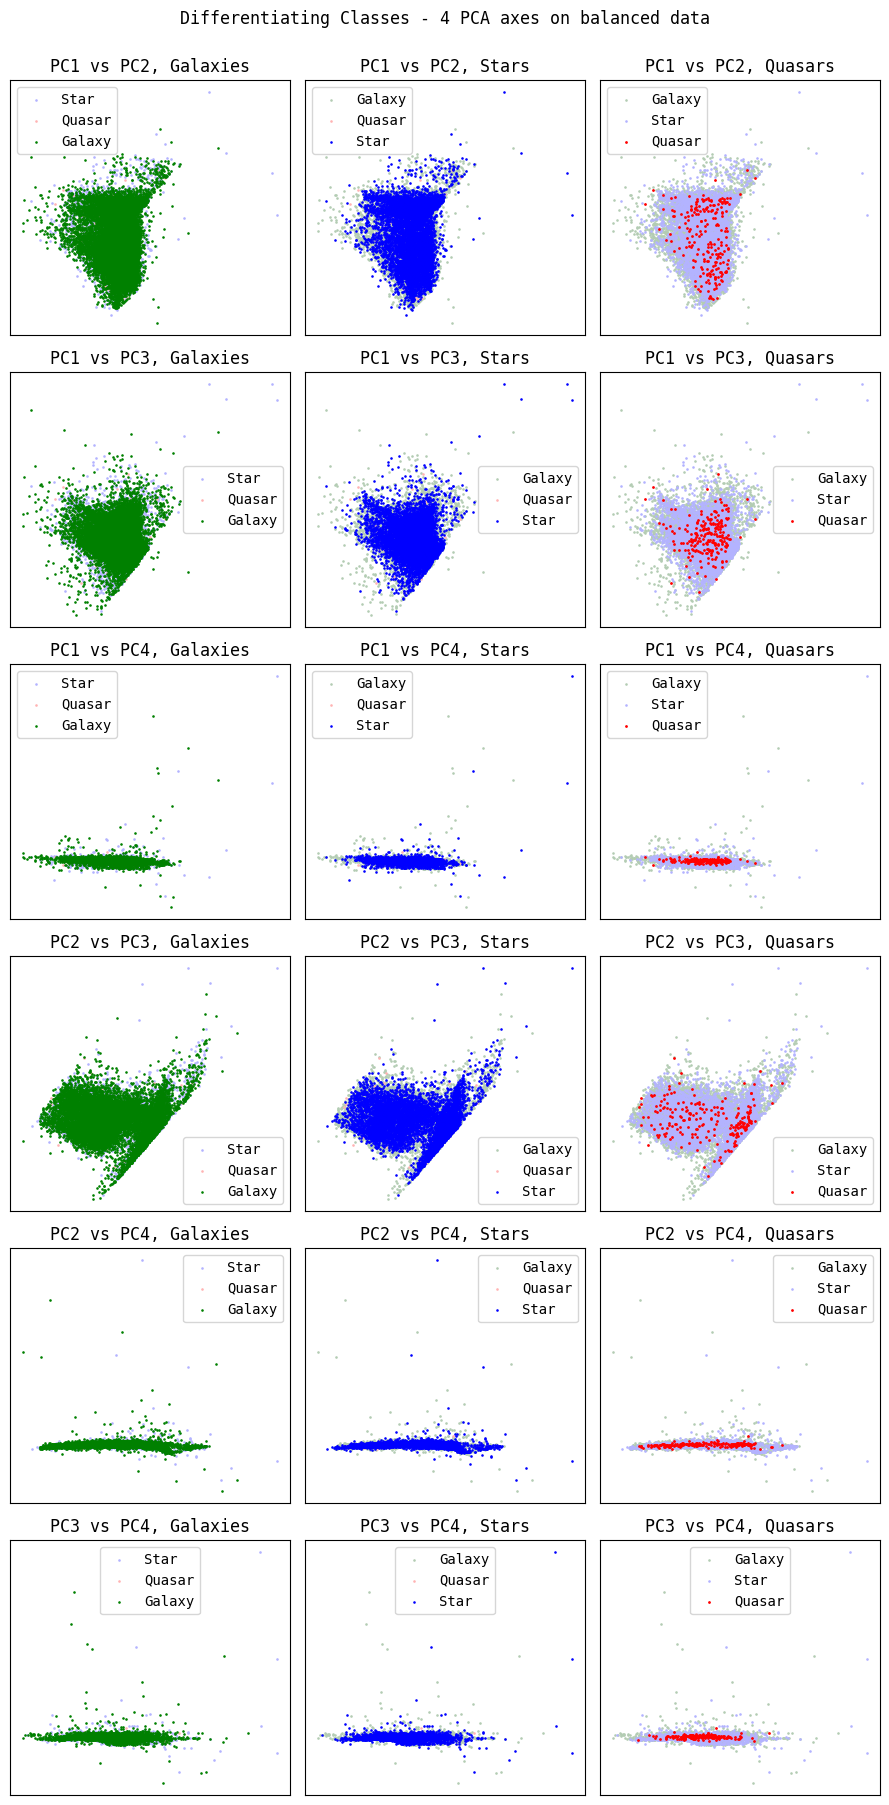

In [ ]:
pcs = "1234"

views     = list(itertools.combinations(pcs, 2))
width     = 3
height    = len(views)
fig, axss = plt.subplots(height, width, figsize=(width*3, height*3))

fig.suptitle("Differentiating Classes - 4 PCA axes on balanced data", y=1)

for (p1, p2), axs in zip(views, axss):

  axs[0].set_title(f"PC{p1} vs PC{p2}, Galaxies")
  axs[1].set_title(f"PC{p1} vs PC{p2}, Stars")
  axs[2].set_title(f"PC{p1} vs PC{p2}, Quasars")

  axs[0].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==1], tbs_pca_data[f'PC{p2}'][tbs_label==1], color=(.7,.7,1), s=0.75, alpha=1, label="Star")
  axs[0].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==2], tbs_pca_data[f'PC{p2}'][tbs_label==2], color=(1,.7,.7), s=0.75, alpha=1, label="Quasar")
  axs[0].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==0], tbs_pca_data[f'PC{p2}'][tbs_label==0], color="green",   s=0.75, alpha=1, label="Galaxy")

  axs[1].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==0], tbs_pca_data[f'PC{p2}'][tbs_label==0], color=(.7,.8,.7), s=0.75, alpha=1, label="Galaxy")
  axs[1].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==2], tbs_pca_data[f'PC{p2}'][tbs_label==2], color=(1,.7,.7),  s=0.75, alpha=1, label="Quasar")
  axs[1].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==1], tbs_pca_data[f'PC{p2}'][tbs_label==1], color="blue",     s=0.75, alpha=1, label="Star")

  axs[2].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==0], tbs_pca_data[f'PC{p2}'][tbs_label==0], color=(.7,.8,.7), s=0.75, alpha=1, label="Galaxy")
  axs[2].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==1], tbs_pca_data[f'PC{p2}'][tbs_label==1], color=(.7,.7,1),  s=0.75, alpha=1, label="Star")
  axs[2].scatter(tbs_pca_data[f'PC{p1}'][tbs_label==2], tbs_pca_data[f'PC{p2}'][tbs_label==2], color="red",      s=1, alpha=1, label="Quasar")

  for a in axs:
    a.legend()
    a.set_xlabel(f'PC{p1}')
    a.set_ylabel(f'PC{p2}')
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)

  fig.tight_layout()
  fig.show()

# k-means

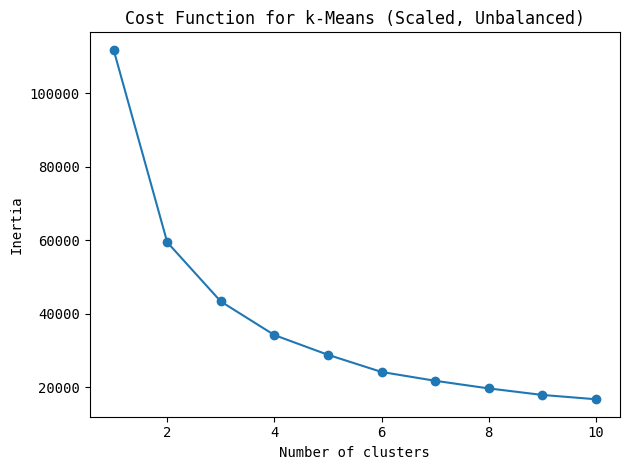

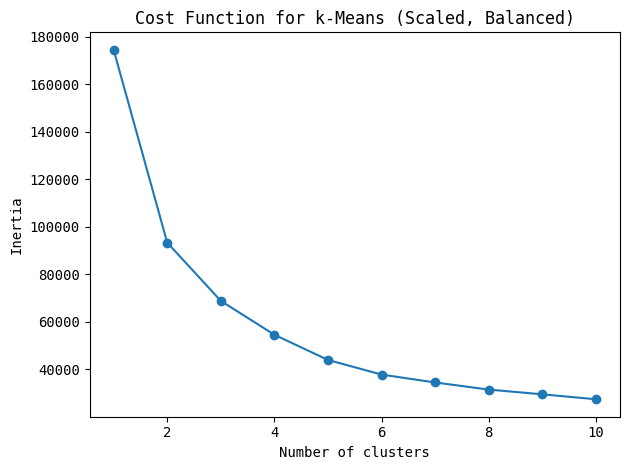

In [ ]:
# Unbalanced, Scaled Data
# Plot the inertia (cost function for k-means) as a function of the number of clusters, k.
# to find the elbow (optimal value for k)
inertia = []
# iterate through candidate values 1-10 for k
for i in range(1, 11):
  km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
  km.fit(ts_data)
  inertia.append(km.inertia_)
# plot
plt.plot(range(1, 11), inertia, marker = 'o')
plt.title('Cost Function for k-Means (Scaled, Unbalanced)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

# The best value for k to use with k-means is k = 2 because this point is
# aligned with where the slope of the inertia function changes the most, i.e.,
# the "elbow" in the plot.

# Balanced, Scaled Data
# Plot the inertia (cost function for k-means)
# to find the elbow (optimal value for k)
inertia = []
# iterate through candidate values 1-10 for k
for i in range(1, 11):
  km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
  km.fit(tbs_data)
  inertia.append(km.inertia_)
# plot
plt.plot(range(1, 11), inertia, marker = 'o')
plt.title('Cost Function for k-Means (Scaled, Balanced)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

# The best value for k to use with k-means is still k = 2 because this point is
# aligned with where the slope of the inertia function changes the most, i.e.,
# the "elbow" in the plot.

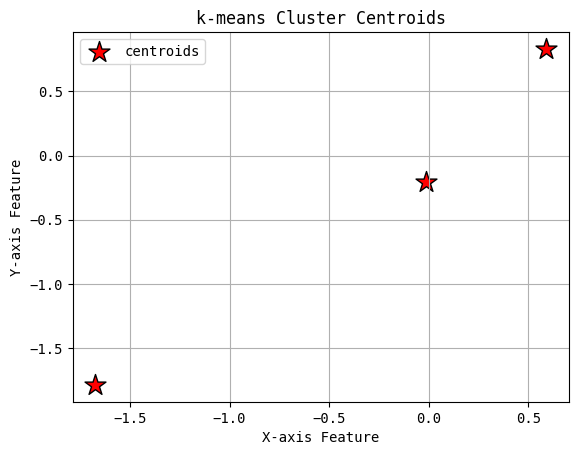

In [ ]:
# Now, use k-means to fit the data above. Store the predicted classes in an array called “y_km”.
# k-Means algorithm for k = 3
km = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=0).fit(tbs_data)
# y_km stores the predicted classes
y_km = km.predict(Ts_data)


# Plot the cluster centers using plt.scatter.
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.title("k-means Cluster Centroids")
plt.xlabel("X-axis Feature")
plt.ylabel("Y-axis Feature")
plt.legend()
plt.grid()
plt.show()

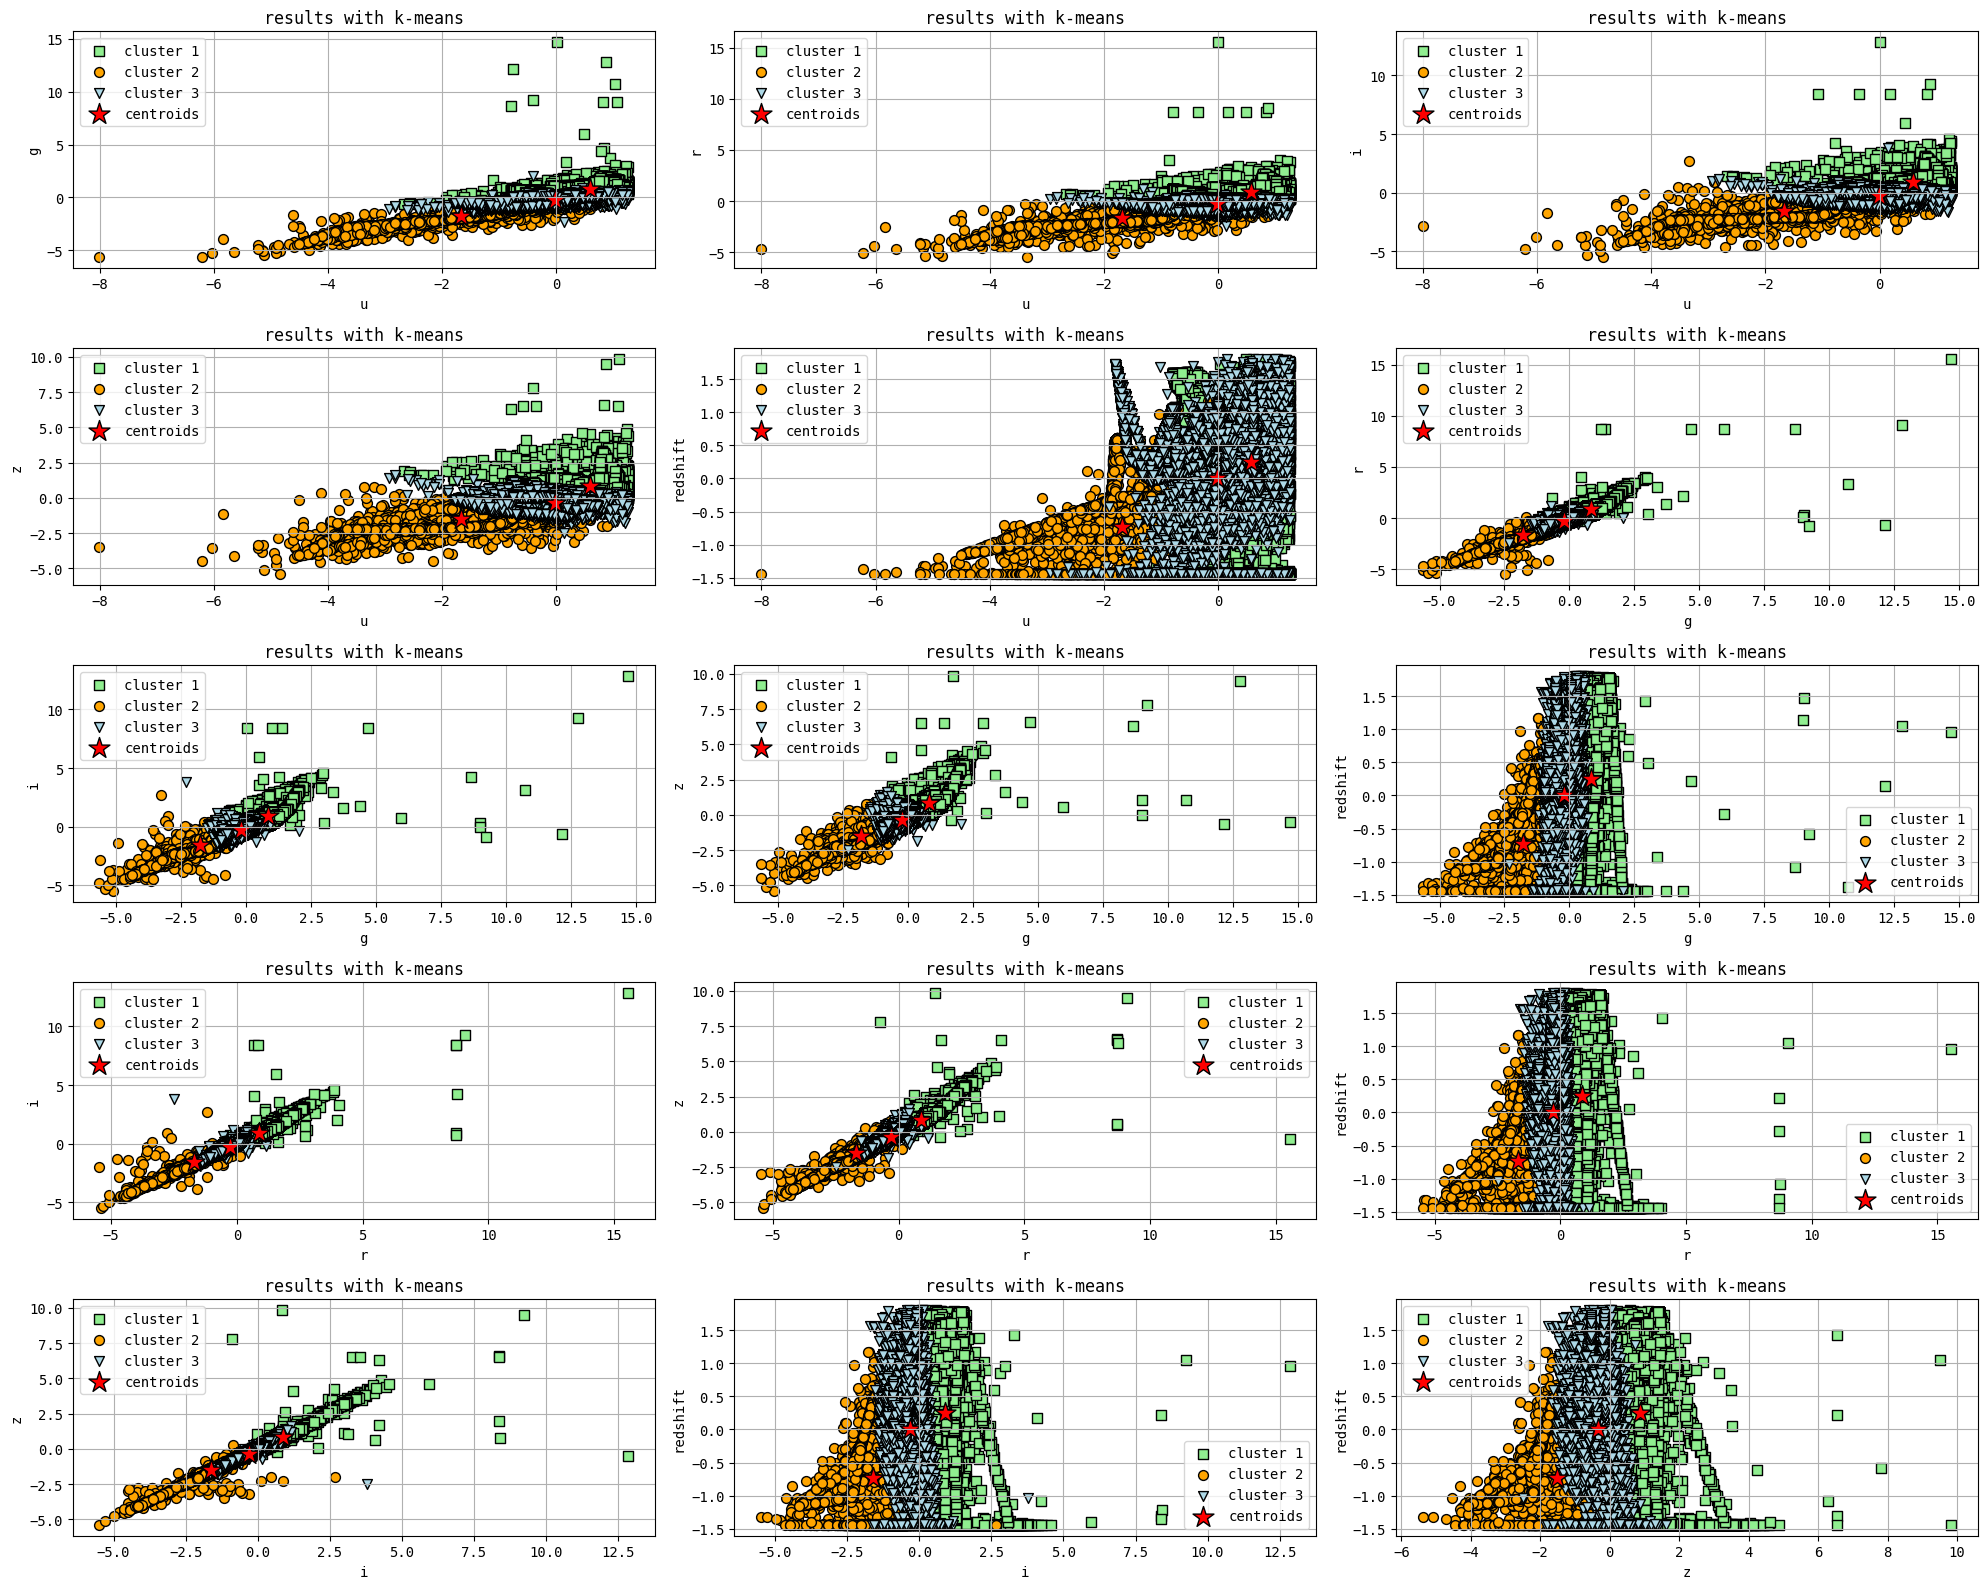

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, random_state=0
)
y = km.fit_predict(tbs_data)

# plot the 3 clusters for each combinations of two variables

# Create a figure with 15 subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 16))
axes = axes.flatten()

column_names = ['u', 'g', 'r', 'i', 'z', 'redshift']
plots = list(itertools.combinations(column_names, 2))

# Loop through each subplot and plot the data
for i, ax in enumerate(axes):

    a1 = plots[i][0]
    a2 = plots[i][1]

    ax.set_title(f'Subplot {i+1}')


    ax.scatter(
      tbs_data[y==0][a1], tbs_data[y==0][a2],
      s=50, c='lightgreen', marker='s', edgecolor='black',
      label='cluster 1')
    ax.scatter(
      tbs_data[y==1][a1], tbs_data[y==1][a2],
      s=50, c='orange', marker='o', edgecolor='black',
      label='cluster 2')
    ax.scatter(
      tbs_data[y==2][a1], tbs_data[y==2][a2],
      s=50, c='lightblue', marker='v', edgecolor='black',
      label='cluster 3')

    ax.scatter(
      km.cluster_centers_[:, column_names.index(a1)], km.cluster_centers_[:, column_names.index(a2)],
      s=250, marker='*',
      c='red', edgecolor='black',
      label='centroids' )

    ax.set_title("results with k-means")
    ax.set_xlabel(a1)
    ax.set_ylabel(a2)
    ax.grid()
    ax.legend()

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plot
plt.show()



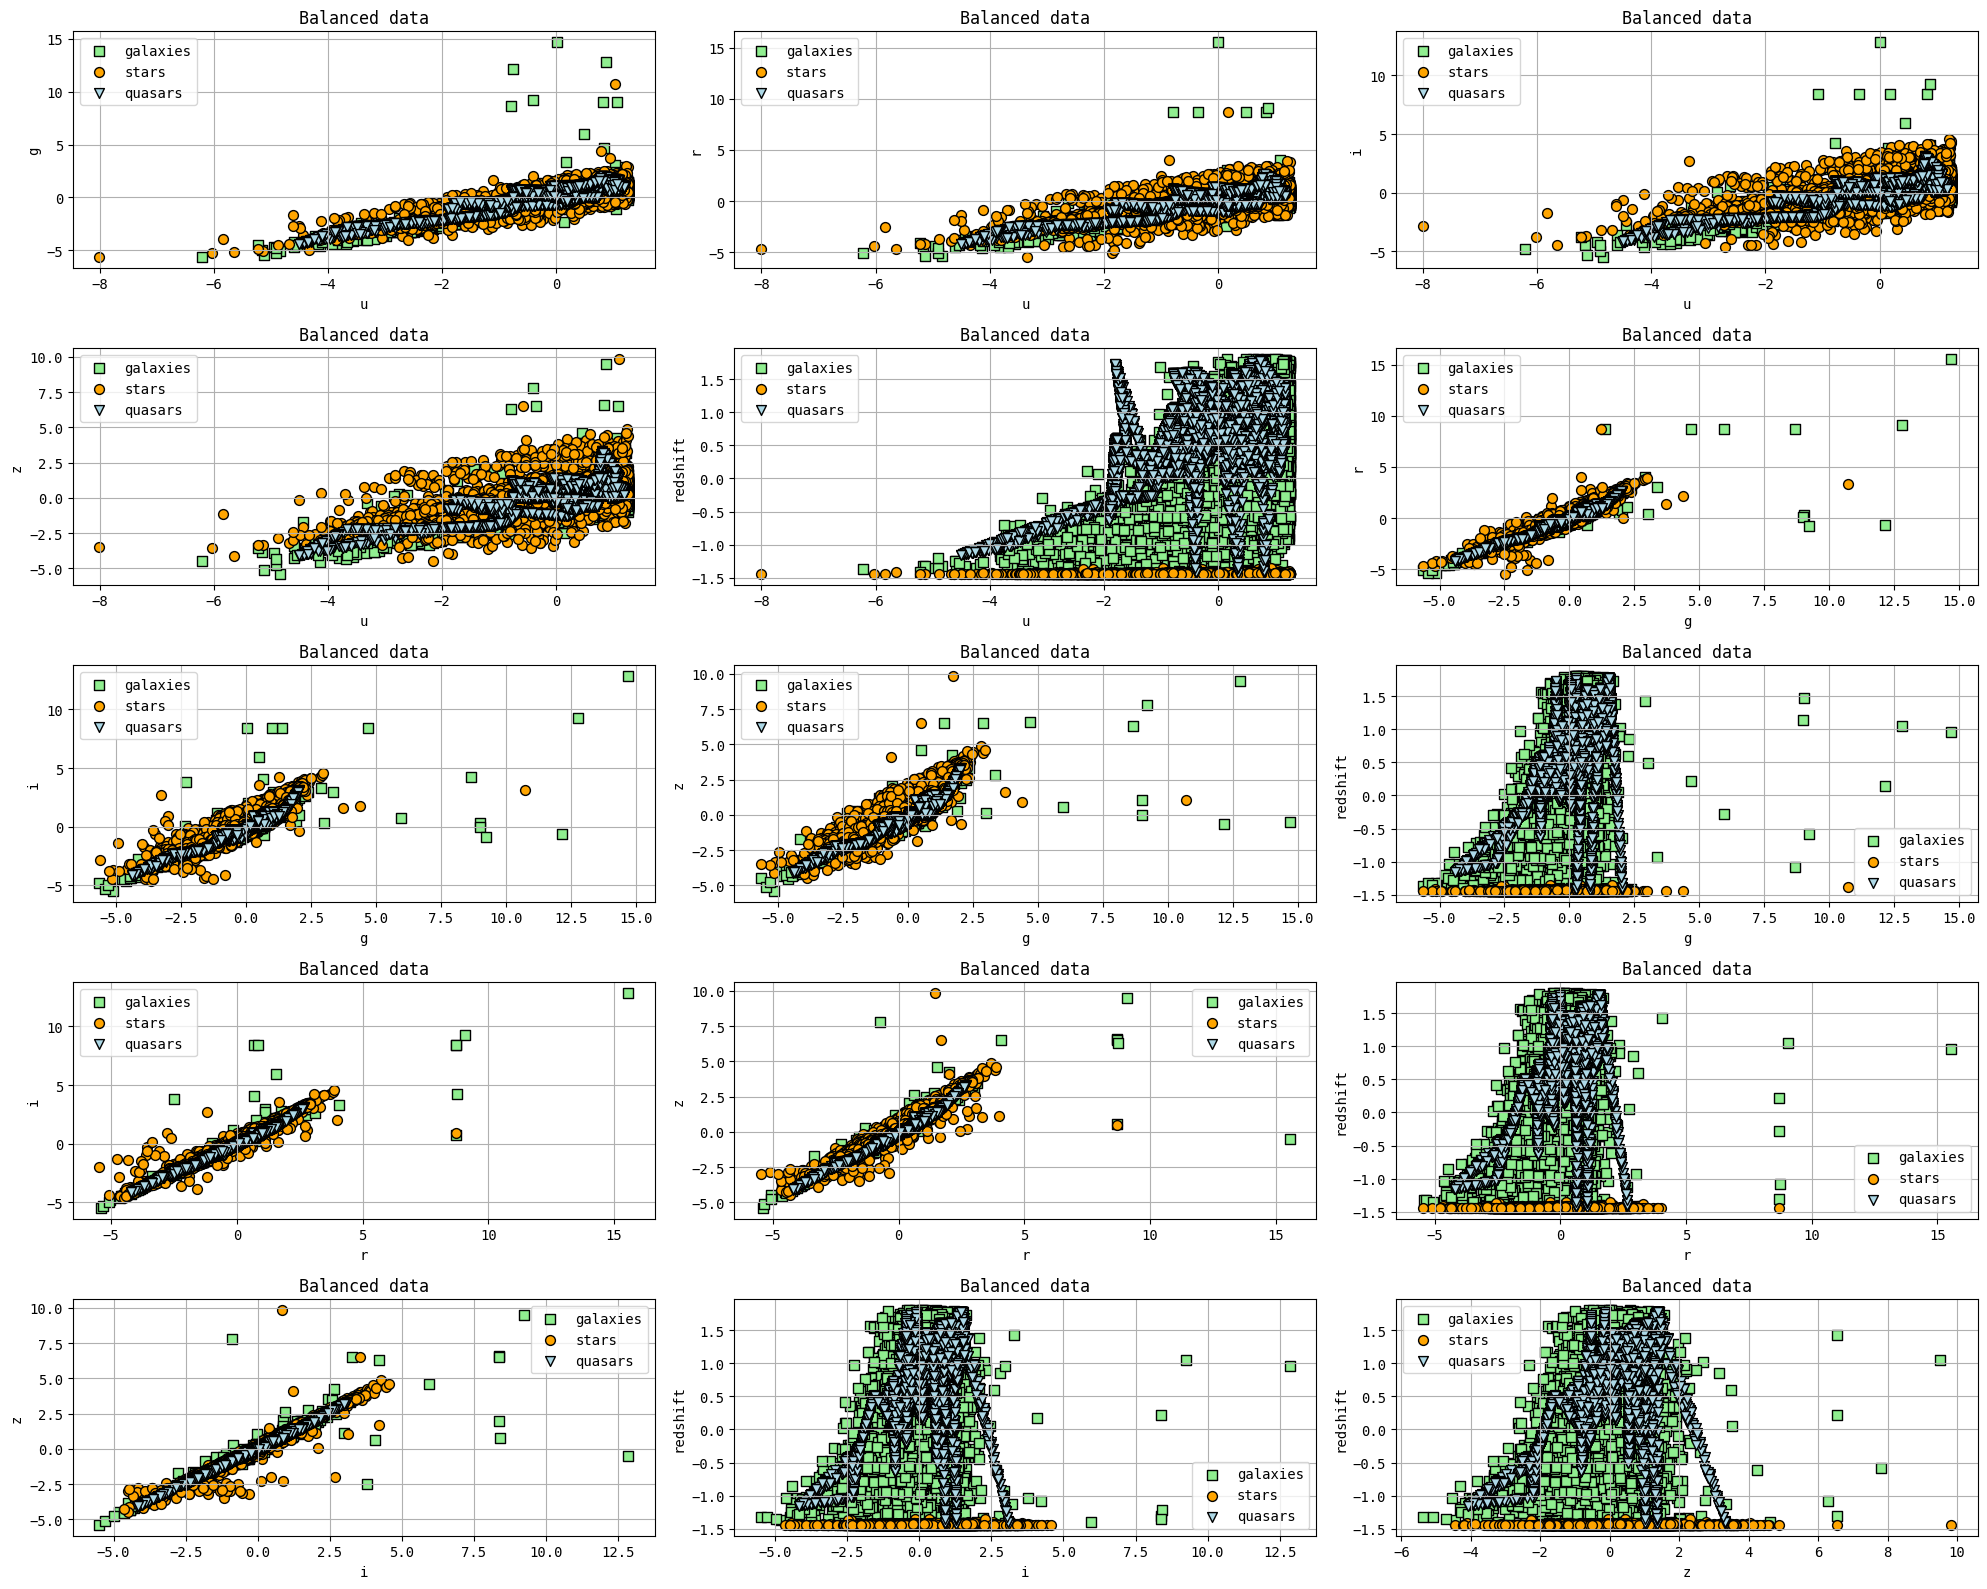

In [ ]:
# comparing to the original balanced data

# plot the 3 clusters for each combinations of two variables

# Create a figure with 15 subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 16))
axes = axes.flatten()

column_names = ['u', 'g', 'r', 'i', 'z', 'redshift']
plots = list(itertools.combinations(column_names, 2))

# Loop through each subplot and plot the data
for i, ax in enumerate(axes):

    a1 = plots[i][0]
    a2 = plots[i][1]

    ax.set_title(f'Subplot {i+1}')


    ax.scatter(
      tbs_data[tbs_label==0][a1], tbs_data[tbs_label==0][a2],
      s=50, c='lightgreen', marker='s', edgecolor='black',
      label='galaxies')
    ax.scatter(
      tbs_data[tbs_label==1][a1], tbs_data[tbs_label==1][a2],
      s=50, c='orange', marker='o', edgecolor='black',
      label='stars')
    ax.scatter(
      tbs_data[tbs_label==2][a1], tbs_data[tbs_label==2][a2],
      s=50, c='lightblue', marker='v', edgecolor='black',
      label='quasars')

    ax.set_title("Balanced data")
    ax.set_xlabel(a1)
    ax.set_ylabel(a2)
    ax.grid()
    ax.legend()

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plot
plt.show()



Classification with k-means Algorithm
Confusion Matrix

 [[2436  891 3144]
 [ 612  357  483]
 [  33   12   32]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.79      0.38      0.51      6471
           1       0.28      0.25      0.26      1452
           2       0.01      0.42      0.02        77

    accuracy                           0.35      8000
   macro avg       0.36      0.35      0.26      8000
weighted avg       0.69      0.35      0.46      8000


Accuracy:0.35313



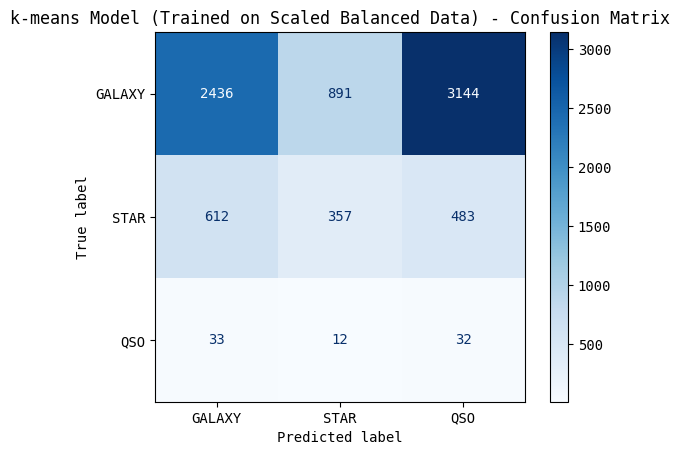

In [ ]:
conf_matrix = confusion_matrix(T_label, y_km)

print("Classification with k-means Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, y_km))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, y_km)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("k-means Model (Trained on Scaled Balanced Data) - Confusion Matrix")
plt.show()

Classification with k-means Algorithm
Confusion Matrix

 [[3393  950 2128]
 [ 417  386  649]
 [  37   12   28]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.88      0.52      0.66      6471
           1       0.29      0.27      0.28      1452
           2       0.01      0.36      0.02        77

    accuracy                           0.48      8000
   macro avg       0.39      0.38      0.32      8000
weighted avg       0.77      0.48      0.58      8000


Accuracy:0.47587



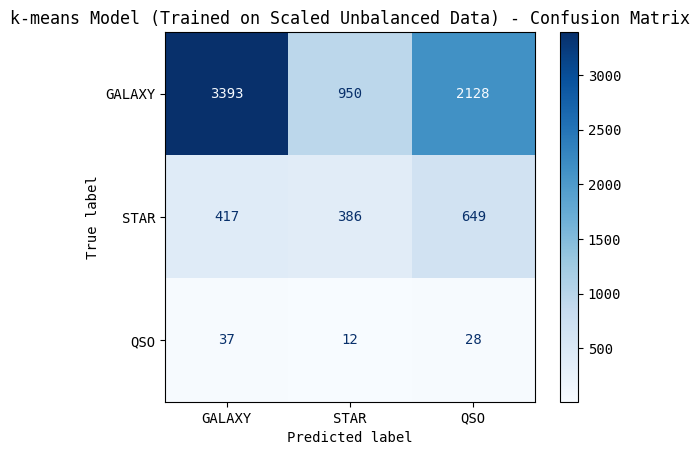

In [ ]:
# Now, use k-means to fit the unbalanced data. Store the predicted classes in an array called “y_km”.
# k-Means algorithm for k = 3
km = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=0).fit(ts_data)
# y_km stores the predicted classes
y_km = km.predict(Ts_data)

conf_matrix = confusion_matrix(T_label, y_km)

print("Classification with k-means Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, y_km))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, y_km)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("k-means Model (Trained on Scaled Unbalanced Data) - Confusion Matrix")
plt.show()

# DBSCAN

In [ ]:
eps_vals = []
mns_vals = []
perfs    = []

for eps in tqdm(np.arange(0.01, 0.5, 0.025)):
  for min_samples in range(2,10):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(training)
    y_db = dbscan.labels_
    perf = (sum(training['class'] == y_db)/len(training['class']))

    eps_vals.append(eps)
    mns_vals.append(min_samples)
    perfs.append(perf)

100%|██████████| 20/20 [03:27<00:00, 10.39s/it]


In [ ]:
idx = perfs.index(max(perfs))
print(eps_vals[idx])
print(mns_vals[idx])

0.48500000000000004
2


0.00022222222222222223

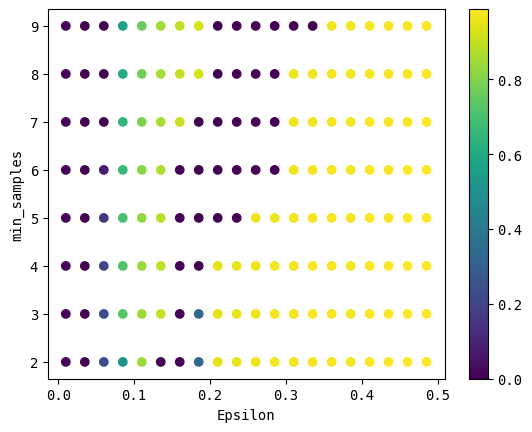

In [ ]:
plt.scatter(eps_vals, mns_vals, c=perfs)
plt.xlabel("Epsilon")
plt.ylabel("min_samples")
plt.colorbar()

In [ ]:
dbscan = DBSCAN(eps=0.4, min_samples=10)
y_db = dbscan.fit_predict(t_data)

print("number of clusters:", len(pd.unique(y_db))-1)
print("training accuracy:", sum(t_label == y_db)/len(t_label))

number of clusters: 3
training accuracy: 0.6229444444444444


Classification with DBSCAN Algorithm
Confusion Matrix

 [[6398    3    0]
 [1310   14   22]
 [  73    0    0]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.82      1.00      0.90      6401
           1       0.82      0.01      0.02      1346
           2       0.00      0.00      0.00        73

    accuracy                           0.82      7820
   macro avg       0.55      0.34      0.31      7820
weighted avg       0.81      0.82      0.74      7820


Accuracy:0.81995



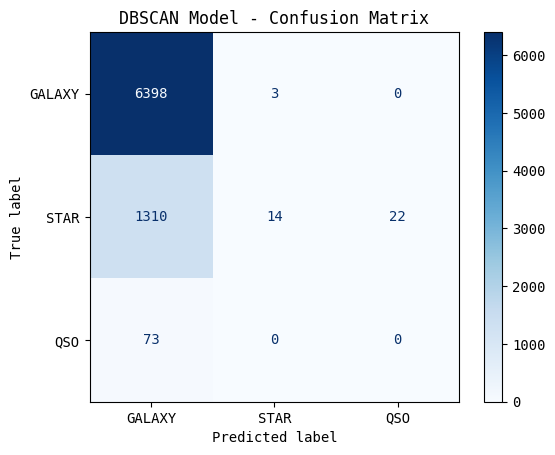

In [ ]:
y_db = dbscan.fit_predict(T_data)

# removing points classified as outliers class -1
T_label_filtered = [x for i, x in enumerate(T_label) if y_db[i] != -1]
y_db = [x for x in y_db if x != -1]

conf_matrix = confusion_matrix(T_label_filtered, y_db)

print("Classification with DBSCAN Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label_filtered, y_db))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label_filtered, y_db)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("DBSCAN Model - Confusion Matrix")
plt.show()

This is bad as the DBSCAN model basically have majority of the points in one class.

# Balancing via Data Duplication

In [ ]:
# Back to our original dataset
df.head()

u         g         r         i         z  class  redshift
0  16.32475  15.41002  15.00167  14.84394  14.72891      0  0.006298
1  17.77235  16.60964  16.73945  16.84984  16.95081      1  0.000047
2  19.13368  17.17648  16.12352  15.66259  15.27726      0  0.111066
3  18.75010  16.81842  15.94924  15.53820  15.21549      0  0.048963
4  18.94942  17.55173  16.97975  16.63628  16.44447      0  0.048947

In [ ]:
print(df['class'].value_counts().sort_index())


# Split into testing and training
# as specified by project directions
training   = df[:18000]
print(training['class'].value_counts().sort_index())
validation = df[18000:22000]
print(validation['class'].value_counts().sort_index())
testing    = df[22000:]
print(testing['class'].value_counts().sort_index())

0    20736
1     9056
2      208
Name: class, dtype: int64
0    11301
1     6596
2      103
Name: class, dtype: int64
0    2964
1    1008
2      28
Name: class, dtype: int64
0    6471
1    1452
2      77
Name: class, dtype: int64


In [ ]:
from sklearn.utils import shuffle

# create a list of all quasars
quasars_training = training[training['class'] == 2]

for i in range(1, 60):
    # Duplicate quasar data (60 of each) and concatenate with the original
    training = pd.concat([training, quasars_training], ignore_index=True)
    training = shuffle(training)

# Check class distribution after augmentation
print(training['class'].value_counts().sort_index())

0    11301
1     6596
2     6180
Name: class, dtype: int64


In [ ]:
print("Training: " + str(len(training)))

Training: 24077


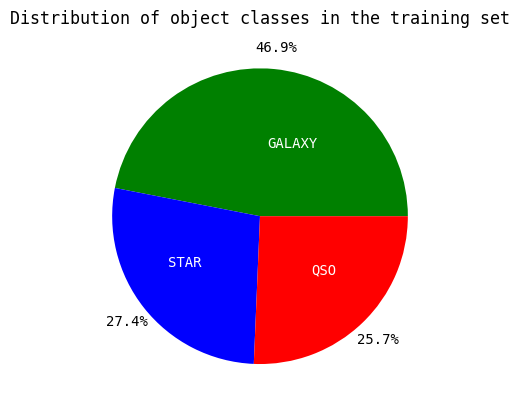

In [ ]:
# Visualize the distribution of classes
_, ls, _ = plt.pie(training['class'].value_counts().sort_index(), labels=["GALAXY", "STAR", "QSO"], colors=("green", "blue", "red"), shadow = False, autopct='%1.1f%%', pctdistance=1.15, labeldistance=0.5)
for l in ls:
  l.set_color("white")
plt.title("Distribution of object classes in the training set")
plt.show()

In [ ]:
# Separate into data and label
tdup_data  = training.drop(["class"], axis=1)
tdup_label = training["class"]

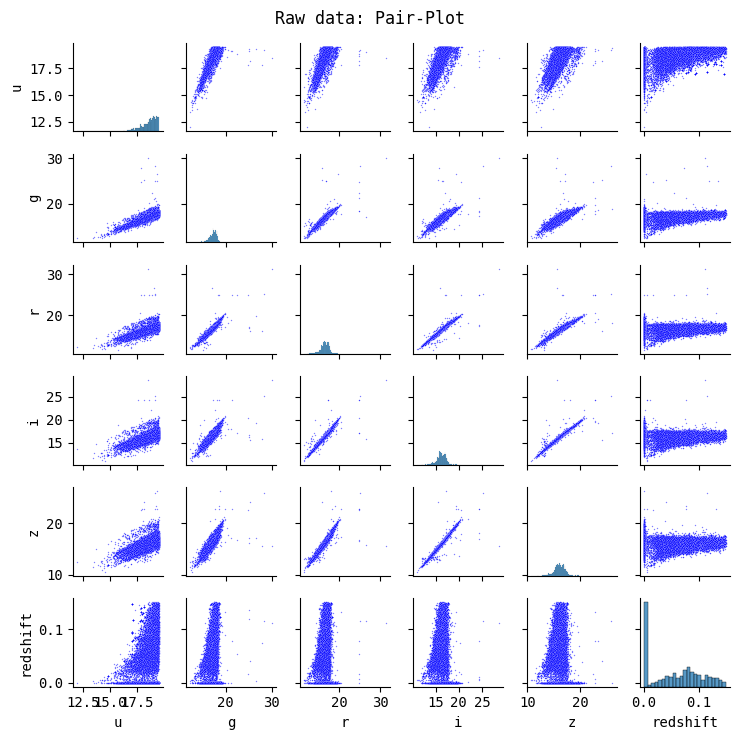

In [ ]:
pp = sns.pairplot(tdup_data, height=1.25, plot_kws={"s": 1, "alpha": 0.5, "color": "blue"})
pp.fig.suptitle("Raw data: Pair-Plot")
pp.fig.tight_layout()
pp.fig.show()

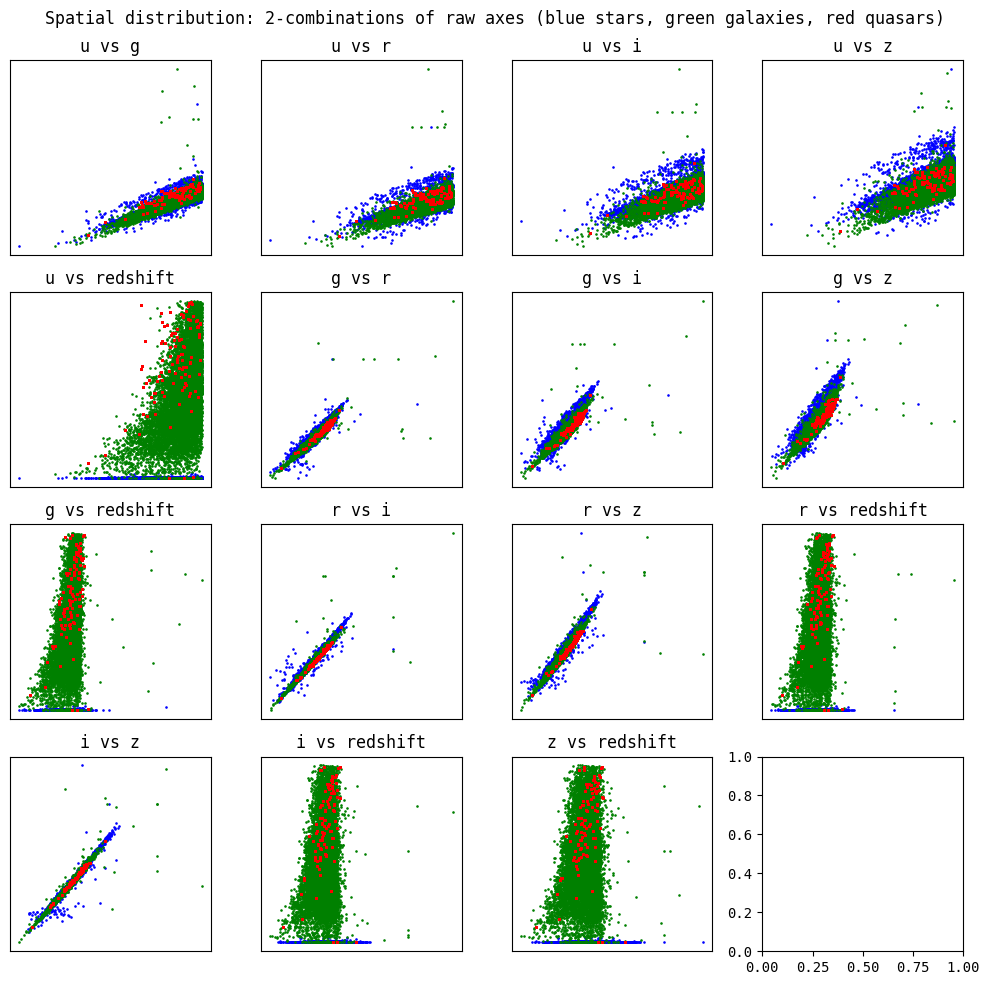

In [ ]:
cols = tdup_data.columns

views   = list(itertools.combinations(cols, 2))
width   = math.ceil(math.sqrt(len(views)))
height  = math.ceil(len(views)/width)
fig, axs = plt.subplots(width, height, figsize=(width*2.5, height*2.5))
axs = axs.flatten()

fig.suptitle("Spatial distribution: 2-combinations of raw axes (blue stars, green galaxies, red quasars)")

for (p1, p2), ax in zip(views, axs):
  ax.set_title(f"{p1} vs {p2}")

  ax.scatter(tdup_data[p1][tdup_label==1], tdup_data[p2][tdup_label==1], color="blue",  s=0.75, alpha=1, label="Star")
  ax.scatter(tdup_data[p1][tdup_label==0], tdup_data[p2][tdup_label==0], color="green", s=0.75, alpha=1, label="Galaxy")
  ax.scatter(tdup_data[p1][tdup_label==2], tdup_data[p2][tdup_label==2], color="red",   s=0.75, alpha=1, label="Quasar")

  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)

  fig.tight_layout()
  fig.show()

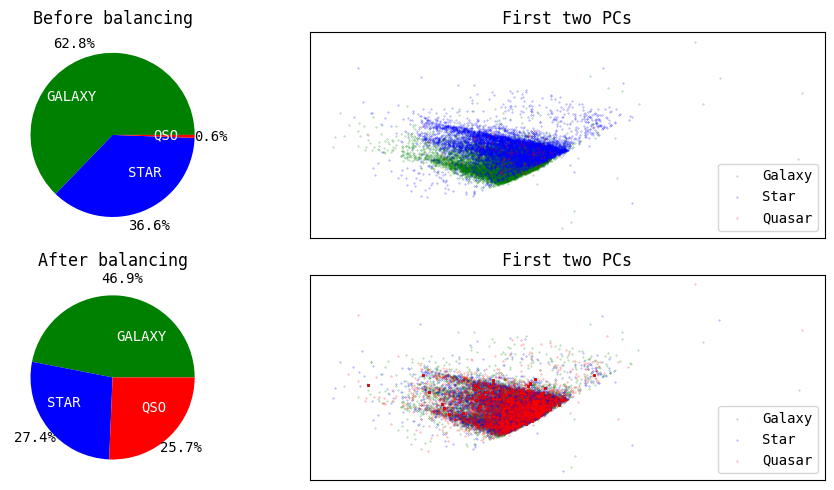

In [ ]:
fig, axss = plt.subplots(2, 2, figsize=(10,5))

for (data, label), title, axs in zip( [(t_data, t_label), (tdup_data, tdup_label)],
                                      ["Before balancing", "After balancing"],
                                      axss ):
  # Plot pie chart
  _, ls, _ = axs[0].pie( label.value_counts().sort_index(),
                         labels=["GALAXY", "STAR", "QSO"],
                         colors=("green", "blue", "red"),
                         autopct='%1.1f%%',
                         pctdistance=1.2,
                         labeldistance=0.5 )

  axs[0].set_title(title)
  for l in ls:
    l.set_color("white")

  # Vis PCA
  pca = PCA(n_components=2)
  df_pca = pd.DataFrame(pca.fit_transform(data), columns=['PC1', 'PC2'])

  axs[1].set_title('First two PCs')

  axs[1].scatter(df_pca['PC1'][label==0], df_pca['PC2'][label==0], color="green", s=0.1, alpha=0.5, label="Galaxy")
  axs[1].scatter(df_pca['PC1'][label==1], df_pca['PC2'][label==1], color="blue",  s=0.1, alpha=0.5, label="Star")
  axs[1].scatter(df_pca['PC1'][label==2], df_pca['PC2'][label==2], color="red",   s=0.1, alpha=0.5,   label="Quasar")

  axs[1].axes.xaxis.set_visible(False)
  axs[1].axes.yaxis.set_visible(False)
  axs[1].legend()

fig.tight_layout()
fig.show()

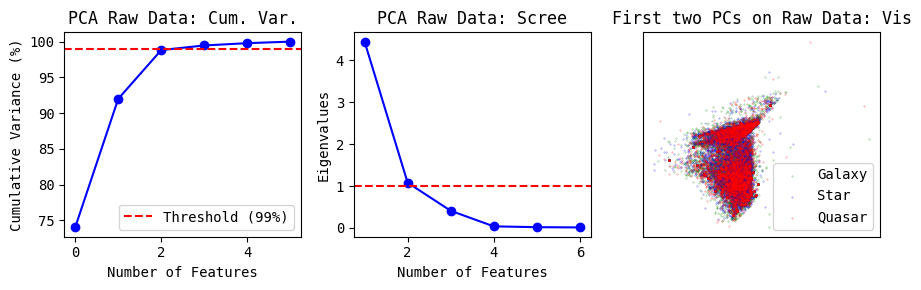

In [ ]:
# Scale both balanced and unbalanced values
data_scaler = StandardScaler().fit(tdup_data)

tdups_data = pd.DataFrame(data_scaler.transform(tdup_data), columns=tdup_data.columns)
tdups_label = tdup_label.copy()

# Also scale unbalanced, validation and testing with same scaler
ts_data3 = pd.DataFrame(data_scaler.transform(t_data), columns=t_data.columns)
vs_data3 = pd.DataFrame(data_scaler.transform(v_data), columns=v_data.columns)
Ts_data3 = pd.DataFrame(data_scaler.transform(T_data), columns=T_data.columns)

# Run PCA
pca = PCA()
pca.fit(tdups_data)

fig, axs = plt.subplots(1, 3, figsize=(9,3))
axs = axs.flatten()

# Plot cumulative variance and threshold
threshold_percentage = 99
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
axs[0].plot(cumulative_variance, marker='o', linestyle='-', color='b')
axs[0].axhline(y=threshold_percentage, color='r', linestyle='--', label=f'Threshold ({threshold_percentage}%)')
axs[0].set_title('PCA Raw Data: Cum. Var.')
axs[0].set_xlabel('Number of Features')
axs[0].set_ylabel('Cumulative Variance (%)')
axs[0].legend()

# Scree Plot to determine the number of features based on eigenvalues
eigenvalues = pca.explained_variance_
axs[1].plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='b')
axs[1].axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1')
axs[1].set_title('PCA Raw Data: Scree')
axs[1].set_xlabel('Number of Features')
axs[1].set_ylabel('Eigenvalues')

# Plot PCA visualization
pca = PCA(n_components=6)
tdups_pca_data = pd.DataFrame(pca.fit_transform(tdups_data), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

axs[2].set_title('First two PCs on Raw Data: Vis')

axs[2].scatter(tdups_pca_data['PC1'][tdups_label==0], tdups_pca_data['PC2'][tdups_label==0], color="green", s=0.1, alpha=0.5, label="Galaxy")
axs[2].scatter(tdups_pca_data['PC1'][tdups_label==1], tdups_pca_data['PC2'][tdups_label==1], color="blue",  s=0.1, alpha=0.5, label="Star")
axs[2].scatter(tdups_pca_data['PC1'][tdups_label==2], tdups_pca_data['PC2'][tdups_label==2], color="red",   s=0.1, alpha=0.5, label="Quasar")

# axs[2].set_xlabel('PC1')
# axs[2].set_ylabel('PC2')
axs[2].axes.xaxis.set_visible(False)
axs[2].axes.yaxis.set_visible(False)
axs[2].legend()

fig.tight_layout()
fig.show()

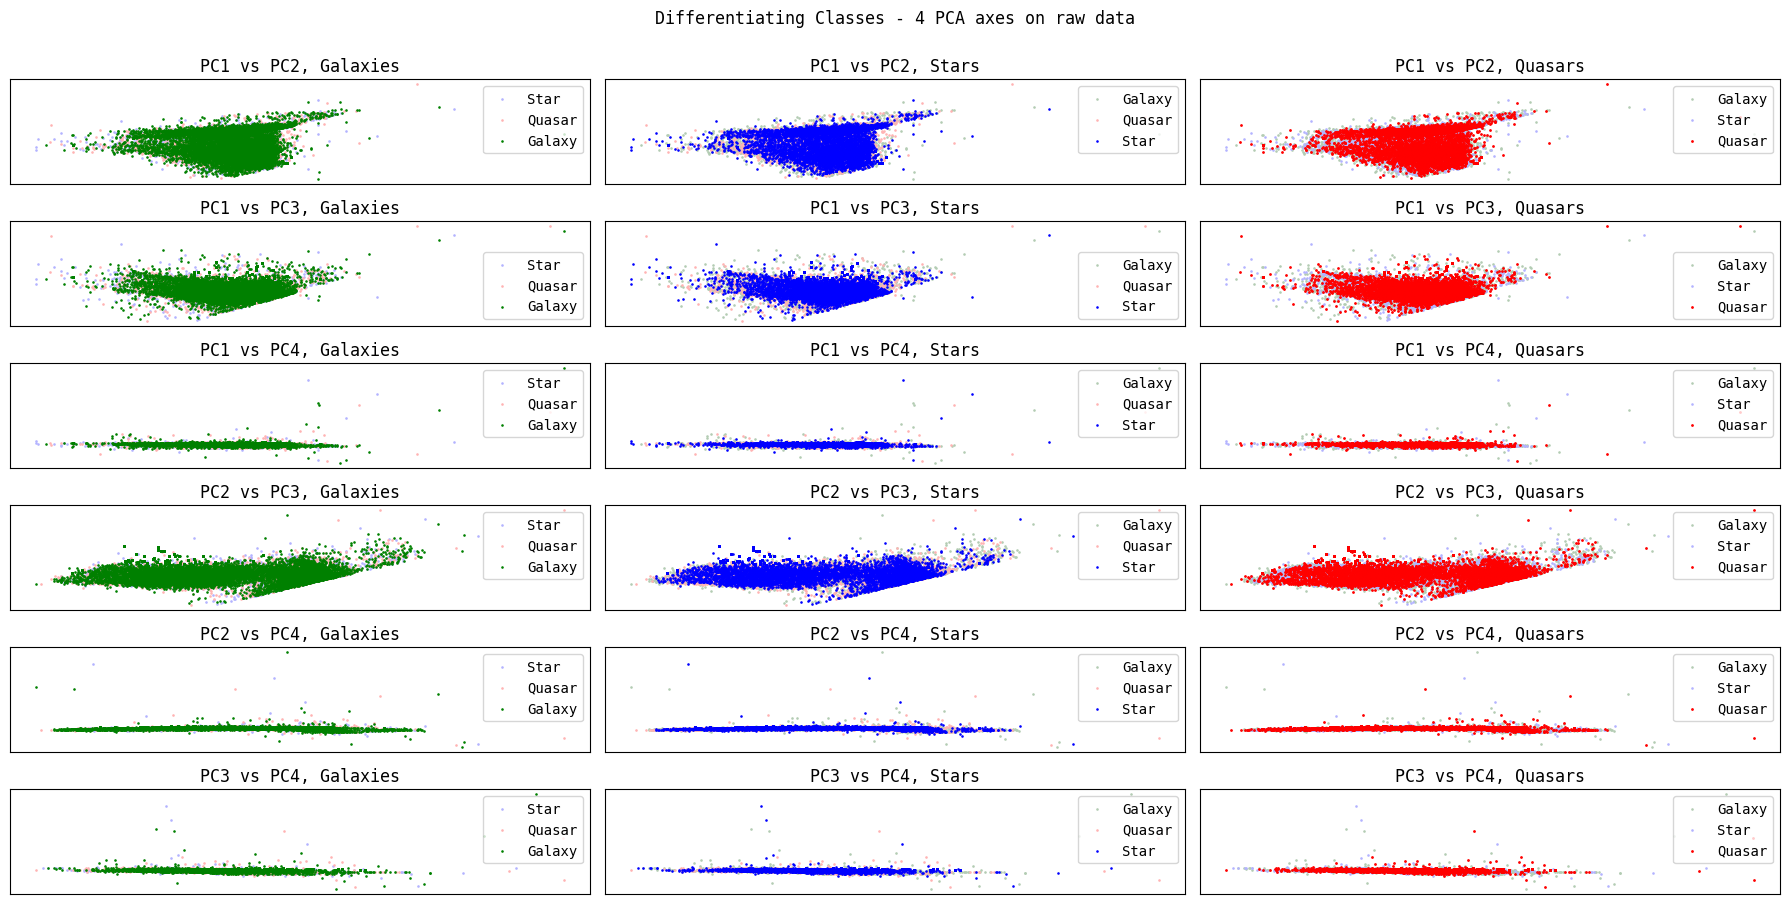

In [ ]:
pcs = "1234"

views     = list(itertools.combinations(pcs, 2))
width     = 3
height    = len(views)
fig, axss = plt.subplots(height, width, figsize=(height*3, width*3))

fig.suptitle("Differentiating Classes - 4 PCA axes on raw data", y=1)

for (p1, p2), axs in zip(views, axss):

  axs[0].set_title(f"PC{p1} vs PC{p2}, Galaxies")
  axs[1].set_title(f"PC{p1} vs PC{p2}, Stars")
  axs[2].set_title(f"PC{p1} vs PC{p2}, Quasars")

  axs[0].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==1], tdups_pca_data[f'PC{p2}'][tdups_label==1], color=(.7,.7,1), s=0.75, alpha=1, label="Star")
  axs[0].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==2], tdups_pca_data[f'PC{p2}'][tdups_label==2], color=(1,.7,.7), s=0.75, alpha=1, label="Quasar")
  axs[0].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==0], tdups_pca_data[f'PC{p2}'][tdups_label==0], color="green",   s=0.75, alpha=1, label="Galaxy")

  axs[1].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==0], tdups_pca_data[f'PC{p2}'][tdups_label==0], color=(.7,.8,.7), s=0.75, alpha=1, label="Galaxy")
  axs[1].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==2], tdups_pca_data[f'PC{p2}'][tdups_label==2], color=(1,.7,.7),  s=0.75, alpha=1, label="Quasar")
  axs[1].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==1], tdups_pca_data[f'PC{p2}'][tdups_label==1], color="blue",     s=0.75, alpha=1, label="Star")

  axs[2].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==0], tdups_pca_data[f'PC{p2}'][tdups_label==0], color=(.7,.8,.7), s=0.75, alpha=1, label="Galaxy")
  axs[2].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==1], tdups_pca_data[f'PC{p2}'][tdups_label==1], color=(.7,.7,1),  s=0.75, alpha=1, label="Star")
  axs[2].scatter(tdups_pca_data[f'PC{p1}'][tdups_label==2], tdups_pca_data[f'PC{p2}'][tdups_label==2], color="red",      s=1, alpha=1, label="Quasar")

  for a in axs:
    a.legend()
    a.set_xlabel(f'PC{p1}')
    a.set_ylabel(f'PC{p2}')
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)

  fig.tight_layout()
  fig.show()

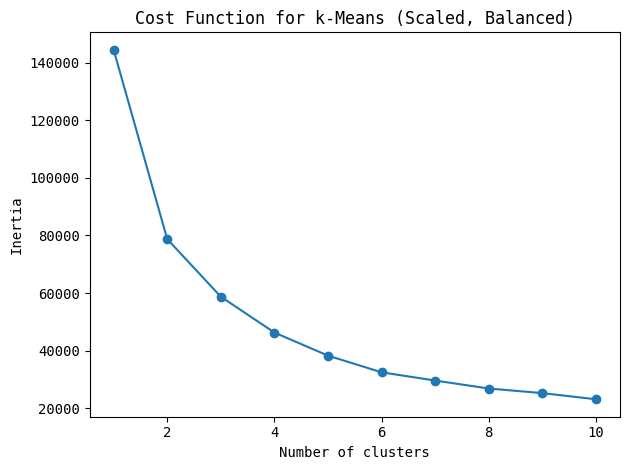

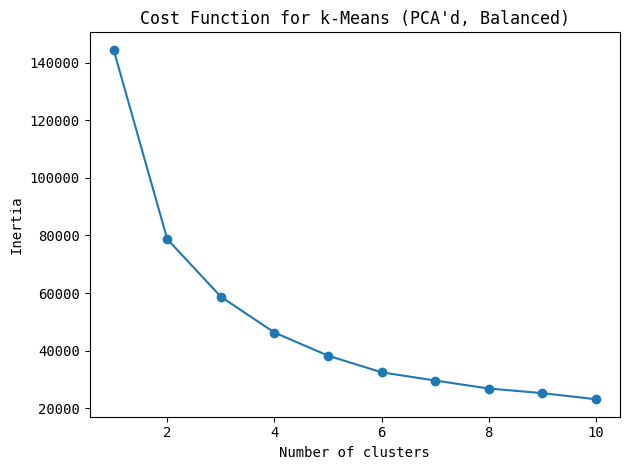

In [ ]:
# Balanced, Scaled Data
# Plot the inertia (cost function for k-means)
# to find the elbow (optimal value for k)
inertia = []
# iterate through candidate values 1-10 for k
for i in range(1, 11):
  km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
  km.fit(tdups_data)
  inertia.append(km.inertia_)
# plot
plt.plot(range(1, 11), inertia, marker = 'o')
plt.title('Cost Function for k-Means (Scaled, Balanced)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()


# Balanced, Scaled, PCA's Data
# Plot the inertia (cost function for k-means)
# to find the elbow (optimal value for k)
inertia = []
# iterate through candidate values 1-10 for k
for i in range(1, 11):
  km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
  km.fit(tdups_pca_data)
  inertia.append(km.inertia_)
# plot
plt.plot(range(1, 11), inertia, marker = 'o')
plt.title("Cost Function for k-Means (PCA'd, Balanced)")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

# The best value for k to use with k-means is k = 3 because this point is
# aligned with where the slope of the inertia function changes the most, i.e.,
# the "elbow" in the plot.

<ipython-input-42-10184af6b0e5>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdups_data[tdups_label==0][a1], tdups_data[tdups_label==0][a2],
<ipython-input-42-10184af6b0e5>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdups_data[tdups_label==1][a1], tdups_data[tdups_label==1][a2],
<ipython-input-42-10184af6b0e5>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdups_data[tdups_label==2][a1], tdups_data[tdups_label==2][a2],


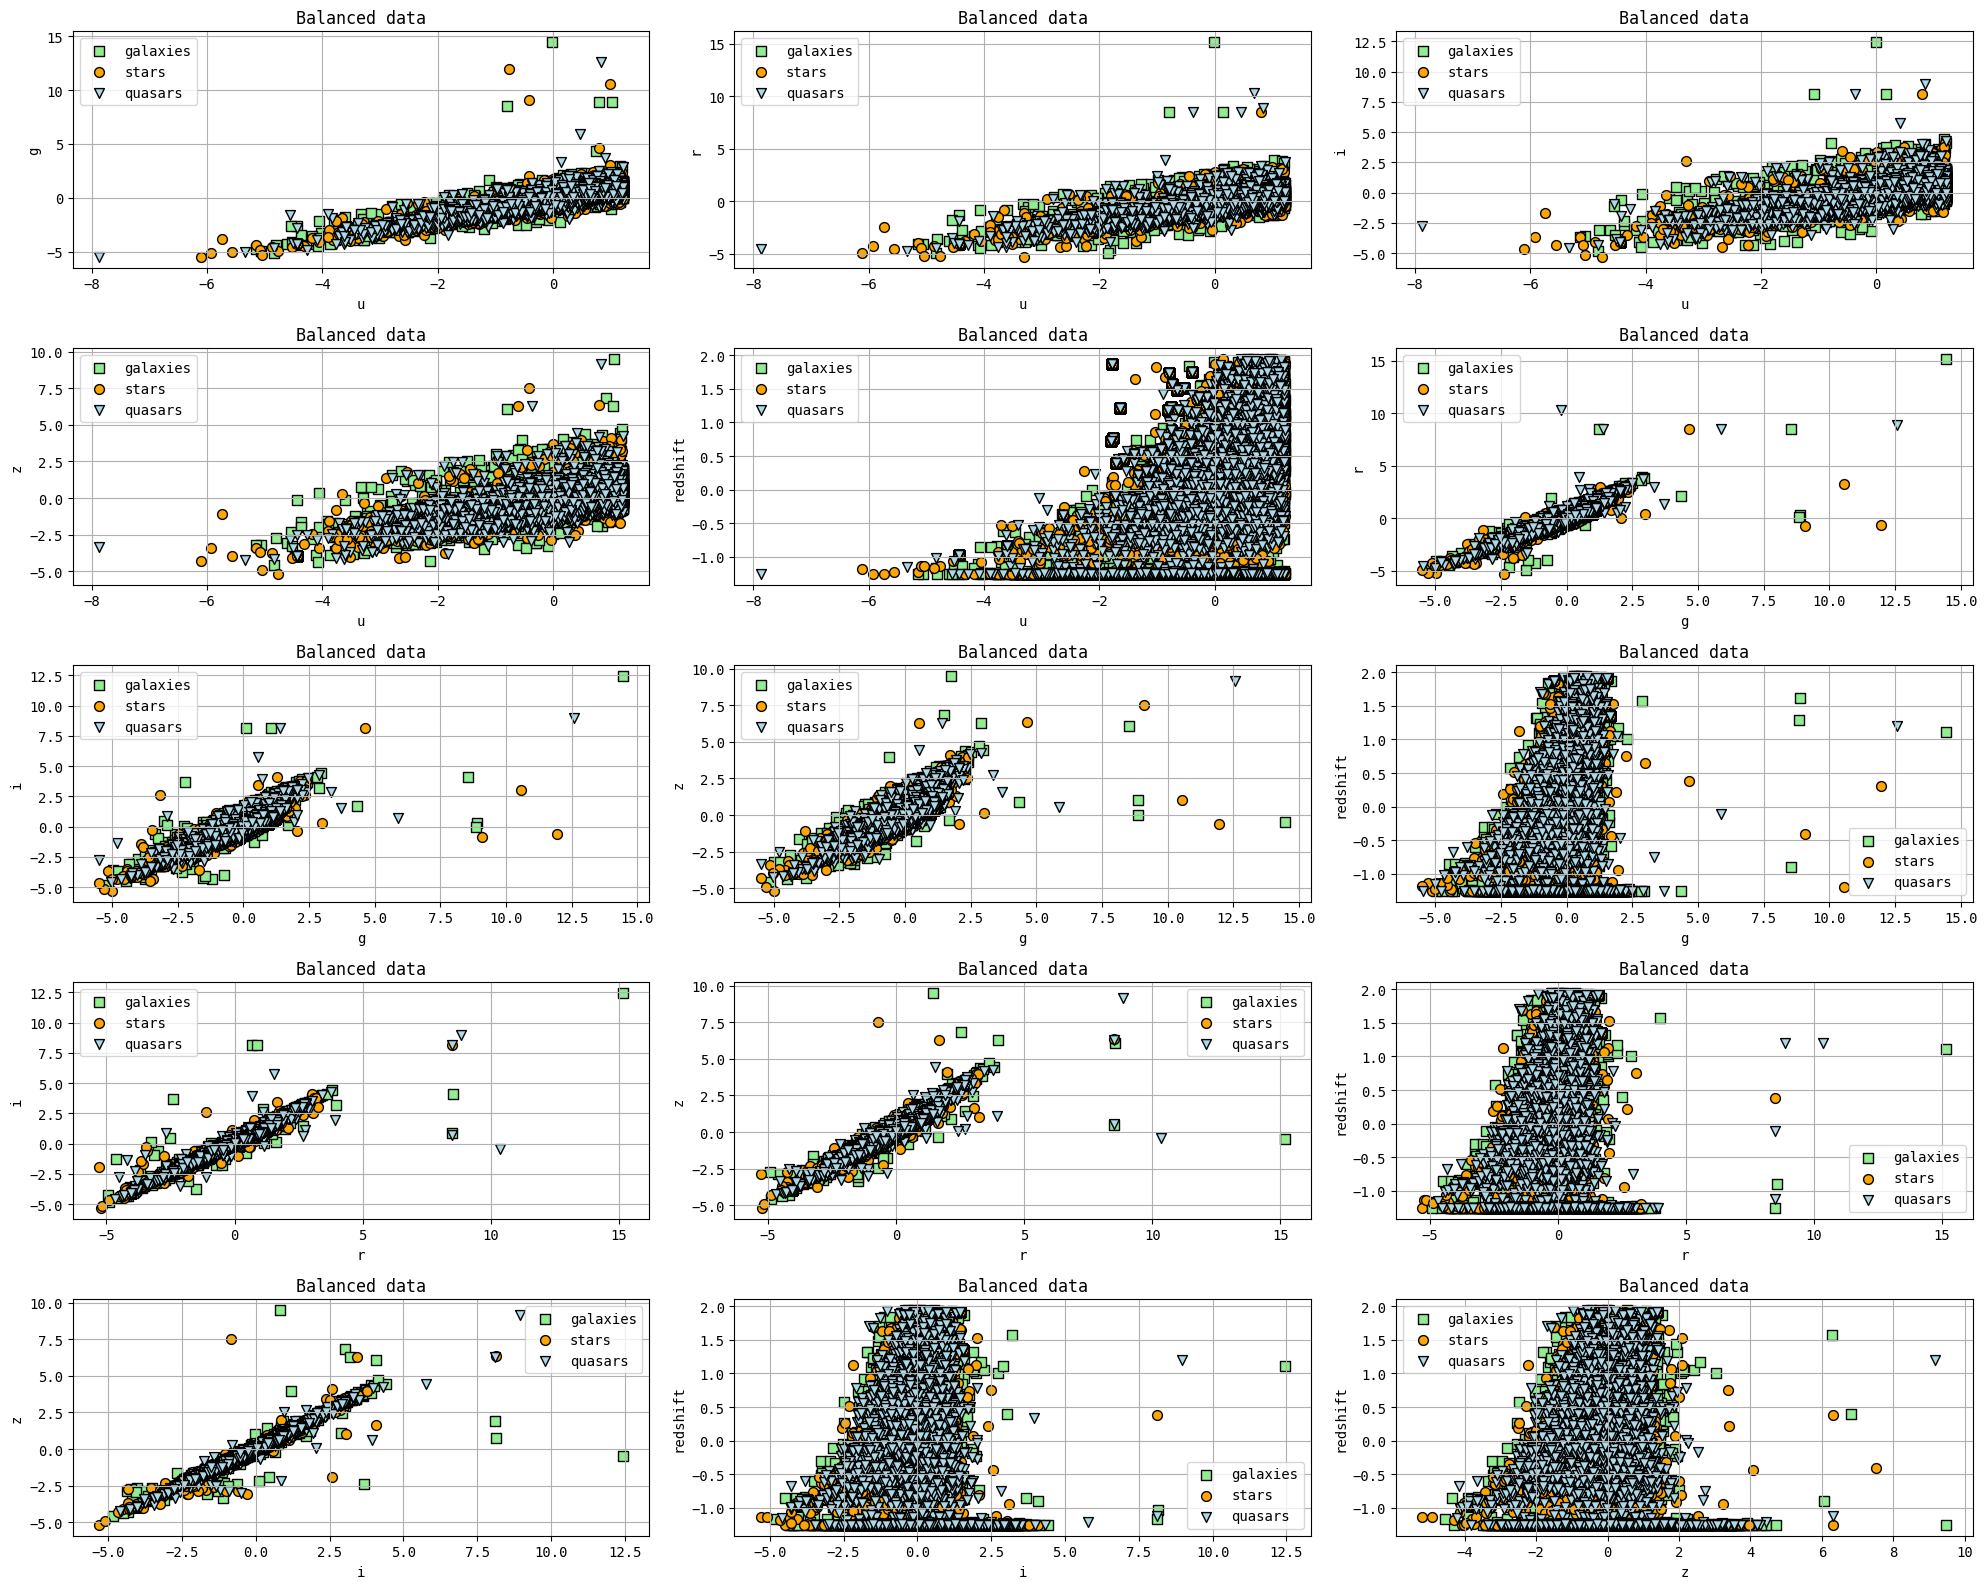

In [ ]:
# plot the 3 clusters for each combinations of two variables

# Create a figure with 15 subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 16))
axes = axes.flatten()

column_names = ['u', 'g', 'r', 'i', 'z', 'redshift']
plots = list(itertools.combinations(column_names, 2))

# Loop through each subplot and plot the data
for i, ax in enumerate(axes):

    a1 = plots[i][0]
    a2 = plots[i][1]

    ax.set_title(f'Subplot {i+1}')


    ax.scatter(
      tdups_data[tdups_label==0][a1], tdups_data[tdups_label==0][a2],
      s=50, c='lightgreen', marker='s', edgecolor='black',
      label='galaxies')
    ax.scatter(
      tdups_data[tdups_label==1][a1], tdups_data[tdups_label==1][a2],
      s=50, c='orange', marker='o', edgecolor='black',
      label='stars')
    ax.scatter(
      tdups_data[tdups_label==2][a1], tdups_data[tdups_label==2][a2],
      s=50, c='lightblue', marker='v', edgecolor='black',
      label='quasars')

    ax.set_title("Balanced data (Data Duplication)")
    ax.set_xlabel(a1)
    ax.set_ylabel(a2)
    ax.grid()
    ax.legend()

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plot
plt.show()


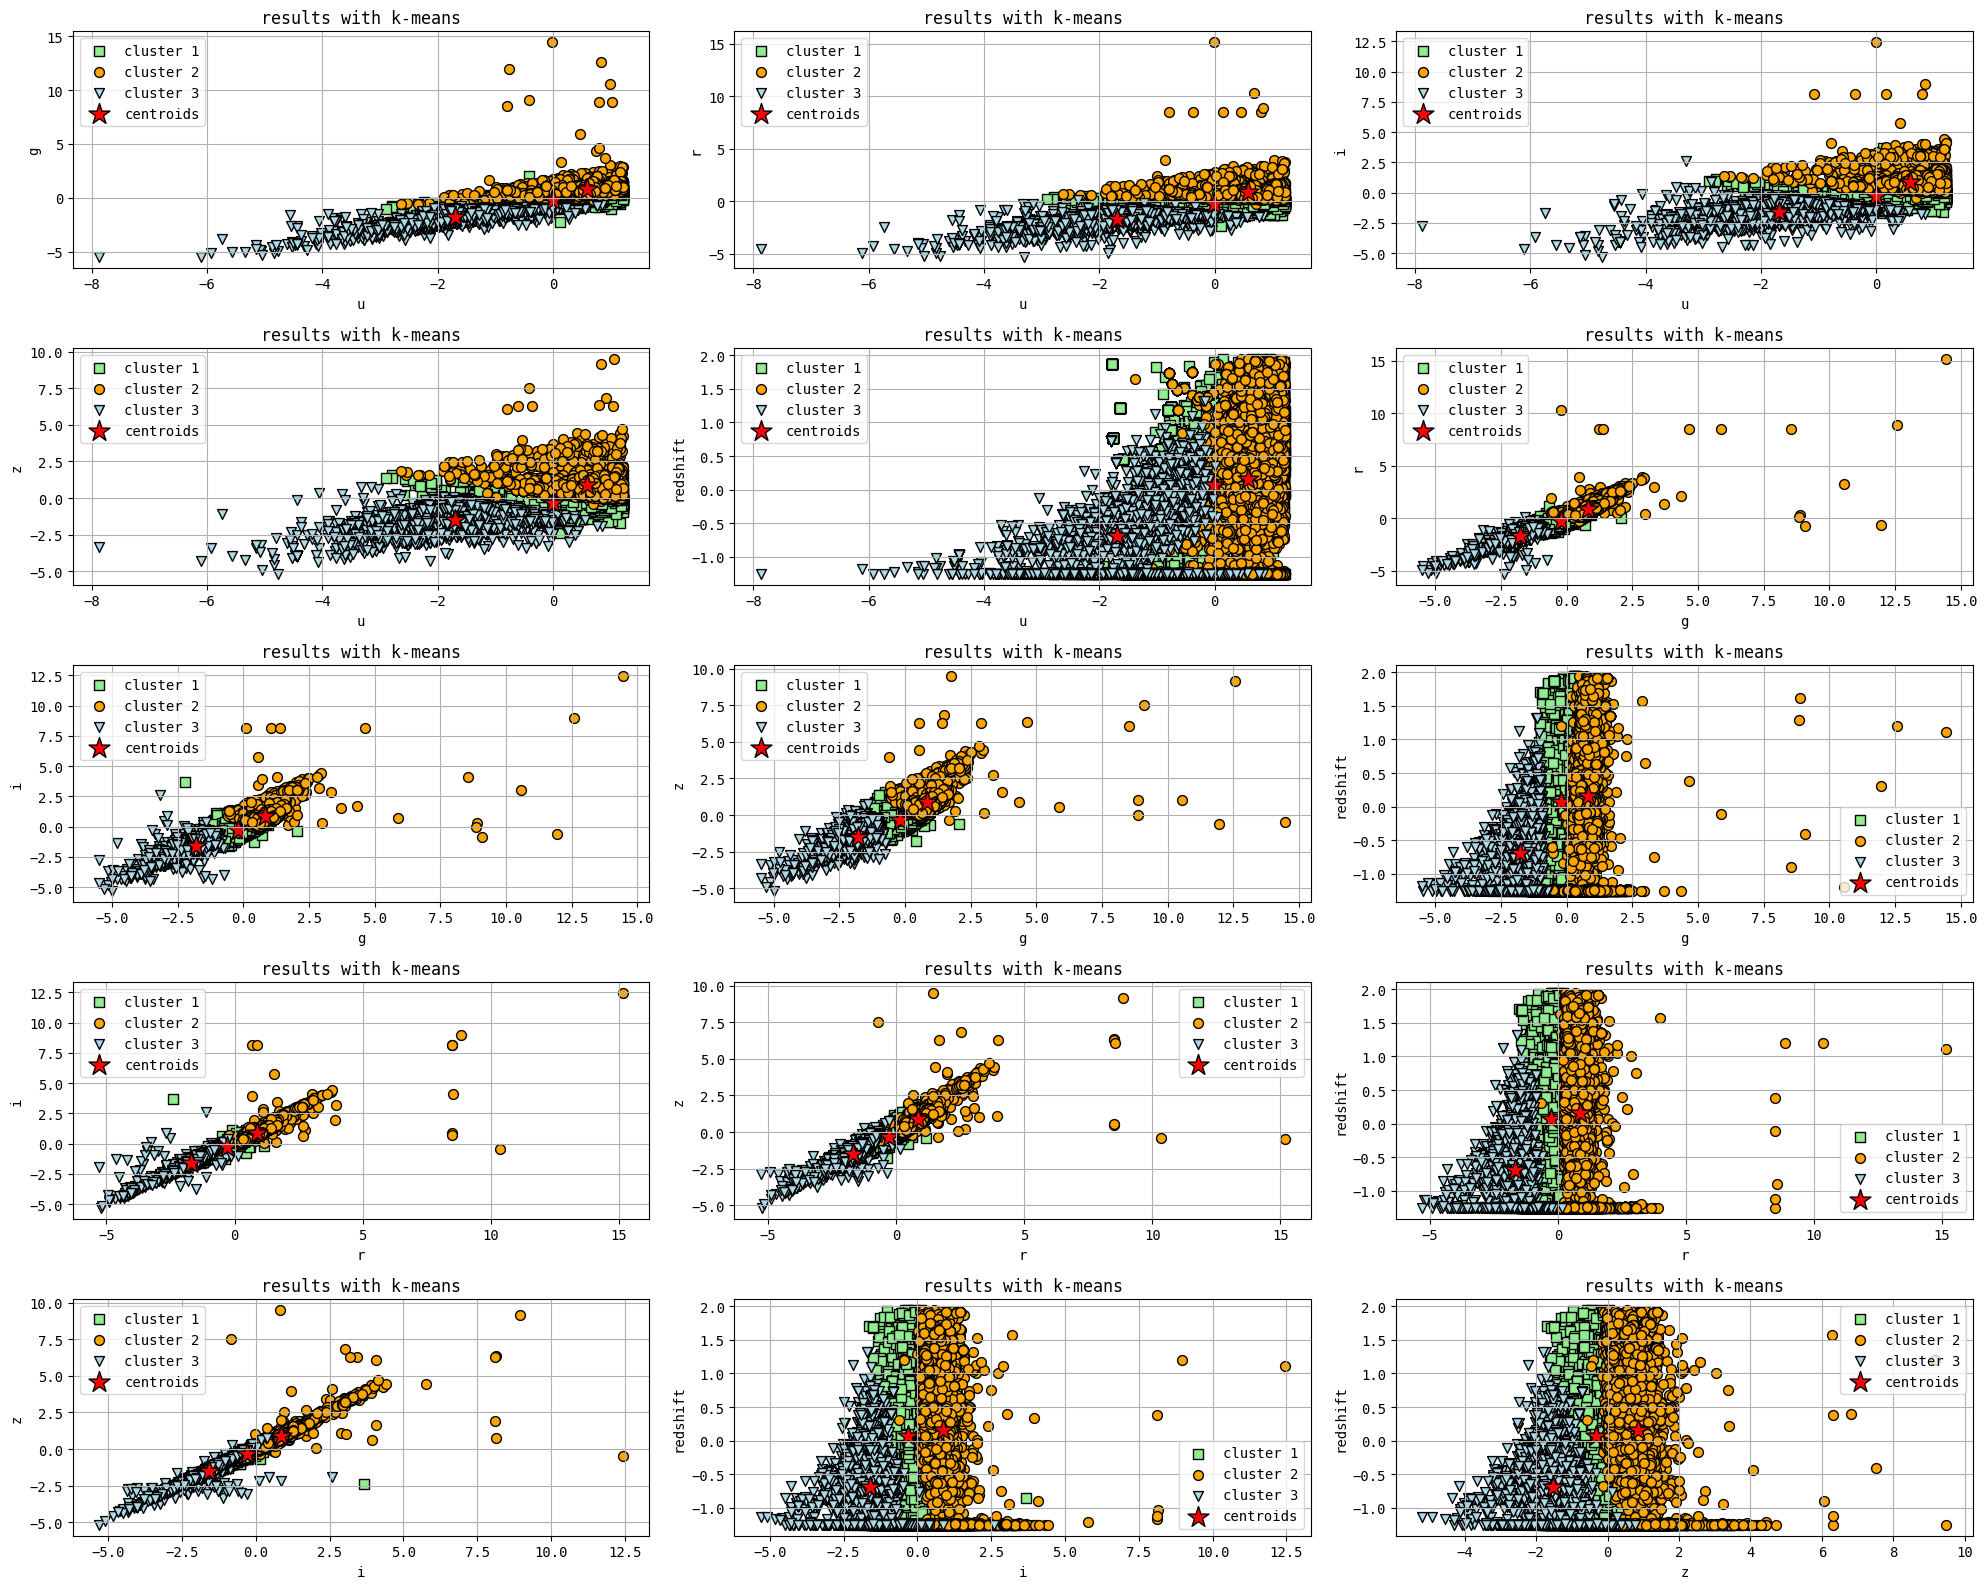

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, random_state=0
)
y = km.fit_predict(tdups_data)

# plot the 3 clusters for each combinations of two variables

# Create a figure with 15 subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 16))
axes = axes.flatten()

column_names = ['u', 'g', 'r', 'i', 'z', 'redshift']
plots = list(itertools.combinations(column_names, 2))

# Loop through each subplot and plot the data
for i, ax in enumerate(axes):

    a1 = plots[i][0]
    a2 = plots[i][1]

    ax.set_title(f'Subplot {i+1}')


    ax.scatter(
      tdups_data[y==0][a1], tdups_data[y==0][a2],
      s=50, c='lightgreen', marker='s', edgecolor='black',
      label='cluster 1')
    ax.scatter(
      tdups_data[y==1][a1], tdups_data[y==1][a2],
      s=50, c='orange', marker='o', edgecolor='black',
      label='cluster 2')
    ax.scatter(
      tdups_data[y==2][a1], tdups_data[y==2][a2],
      s=50, c='lightblue', marker='v', edgecolor='black',
      label='cluster 3')

    ax.scatter(
      km.cluster_centers_[:, column_names.index(a1)], km.cluster_centers_[:, column_names.index(a2)],
      s=250, marker='*',
      c='red', edgecolor='black',
      label='centroids' )

    ax.set_title("results with k-means (Data Duplication)")
    ax.set_xlabel(a1)
    ax.set_ylabel(a2)
    ax.grid()
    ax.legend()

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plot
plt.show()


Classification with k-means Algorithm
Confusion Matrix

 [[3168 2475  828]
 [ 474  636  342]
 [  33   33   11]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.86      0.49      0.62      6471
           1       0.20      0.44      0.28      1452
           2       0.01      0.14      0.02        77

    accuracy                           0.48      8000
   macro avg       0.36      0.36      0.31      8000
weighted avg       0.73      0.48      0.56      8000


Accuracy:0.47687



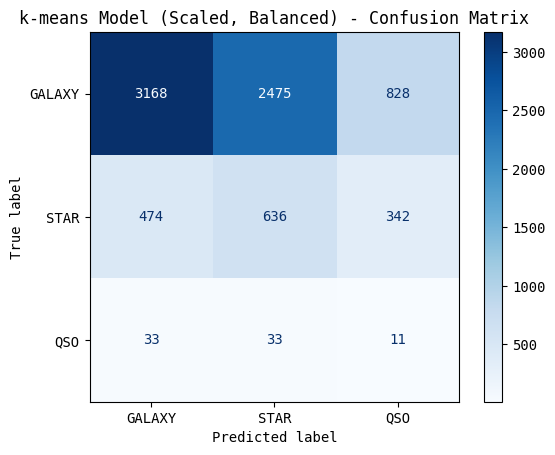

In [ ]:
# Now, use k-means to fit the data above. Store the predicted classes in an array called “y_km”.
# k-Means algorithm for k = 3
km = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=0).fit(tdups_data)
# y_km stores the predicted classes
y_km = km.predict(Ts_data3)


conf_matrix = confusion_matrix(T_label, y_km)

print("Classification with k-means Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, y_km))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, y_km)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("k-means Model (Scaled, Balanced) - Confusion Matrix")
plt.show()

Classification with k-means Algorithm
Confusion Matrix

 [[3233 2363  875]
 [ 515  651  286]
 [  33   32   12]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.86      0.50      0.63      6471
           1       0.21      0.45      0.29      1452
           2       0.01      0.16      0.02        77

    accuracy                           0.49      8000
   macro avg       0.36      0.37      0.31      8000
weighted avg       0.73      0.49      0.56      8000


Accuracy:0.48700



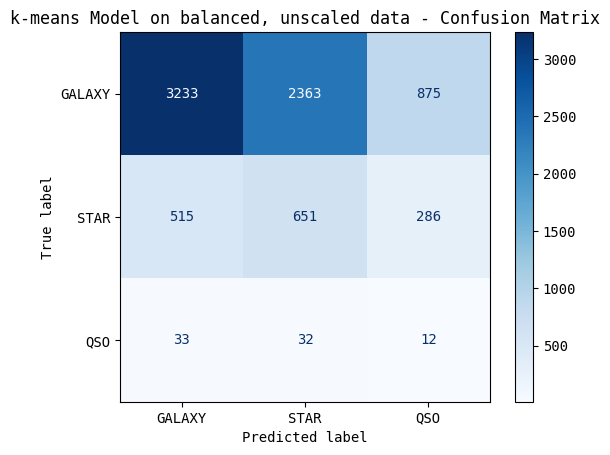

In [ ]:
# Now, use k-means to fit the data above. Store the predicted classes in an array called “y_km”.
# k-Means algorithm for k = 3
km = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=0).fit(tdup_data)
# y_km stores the predicted classes
y_km = km.predict(T_data)


conf_matrix = confusion_matrix(T_label, y_km)

print("Classification with k-means Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, y_km))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, y_km)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("k-means Model on balanced, unscaled data - Confusion Matrix")
plt.show()

In [ ]:
# # Now, use k-means to fit the data above. Store the predicted classes in an array called “y_km”.
# # k-Means algorithm for k = 3



# km = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=0).fit(tdups_pca_data)
# # y_km stores the predicted classes
# y_km = km.predict(Ts_data3)


# conf_matrix = confusion_matrix(T_label, y_km)

# print("Classification with k-means Algorithm\nConfusion Matrix\n\n", conf_matrix)

# print('Classification Report: \n\n',classification_report(T_label, y_km))
# print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, y_km)))

# disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
#                                  display_labels=["GALAXY", "STAR", "QSO"])

# disp.plot(cmap=plt.cm.Blues)

# plt.title("k-means Model (PCA'd, Balanced) - Confusion Matrix")
# plt.show()

# kMeansSMOTE

Repeat the process of data balancing, this time using KMeansSMOTE (Apply a KMeans clustering before to over-sample using SMOTE).

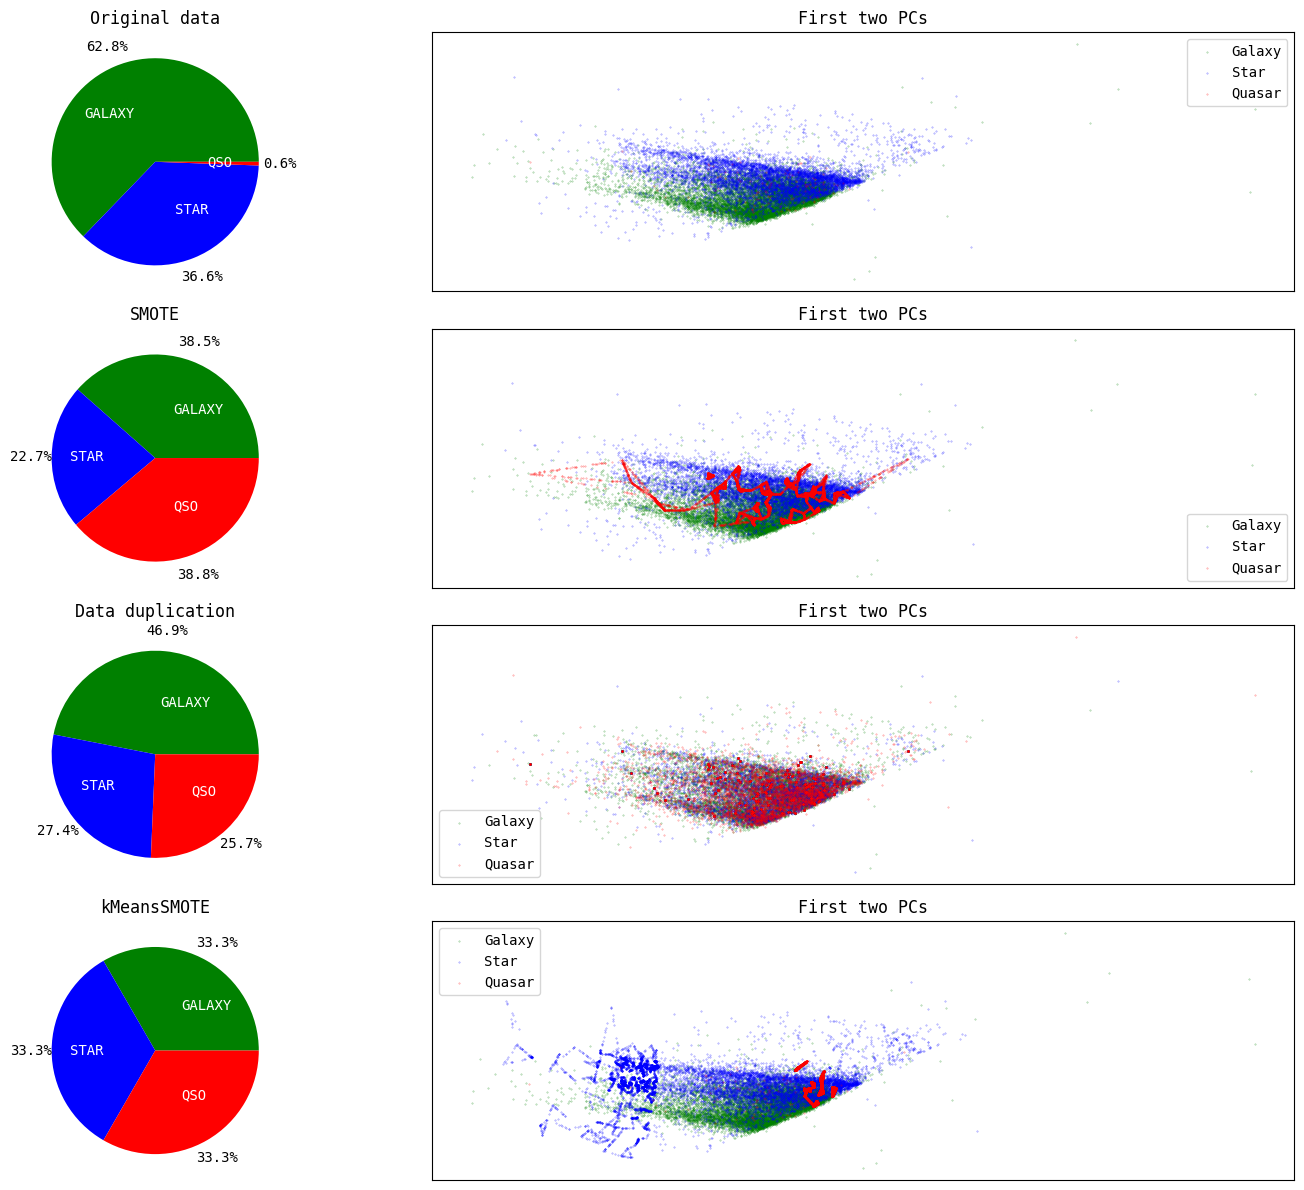

In [ ]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import MiniBatchKMeans

sm = KMeansSMOTE(
    kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42, cluster_balance_threshold=0.007
)
tb_data2, tb_label2 = sm.fit_resample(t_data, t_label)


fig, axss = plt.subplots(4, 2, figsize=(16,12))

for (data, label), title, axs in zip( [(t_data, t_label), (tb_data, tb_label), (tdup_data, tdup_label), (tb_data2, tb_label2)],
                                      ["Original data", "SMOTE", "Data duplication", "kMeansSMOTE"],
                                      axss ):
  # Plot pie chart
  _, ls, _ = axs[0].pie( label.value_counts().sort_index(),
                         labels=["GALAXY", "STAR", "QSO"],
                         colors=("green", "blue", "red"),
                         autopct='%1.1f%%',
                         pctdistance=1.2,
                         labeldistance=0.5 )

  axs[0].set_title(title)
  for l in ls:
    l.set_color("white")

  # Vis PCA
  pca = PCA(n_components=2)
  df_pca = pd.DataFrame(pca.fit_transform(data), columns=['PC1', 'PC2'])

  axs[1].set_title('First two PCs')

  axs[1].scatter(df_pca['PC1'][label==0], df_pca['PC2'][label==0], color="green", s=0.1, alpha=0.5, label="Galaxy")
  axs[1].scatter(df_pca['PC1'][label==1], df_pca['PC2'][label==1], color="blue",  s=0.1, alpha=0.5, label="Star")
  axs[1].scatter(df_pca['PC1'][label==2], df_pca['PC2'][label==2], color="red",   s=0.1, alpha=0.5,   label="Quasar")

  axs[1].axes.xaxis.set_visible(False)
  axs[1].axes.yaxis.set_visible(False)
  axs[1].legend()

fig.tight_layout()
fig.show()

PCA Visualization

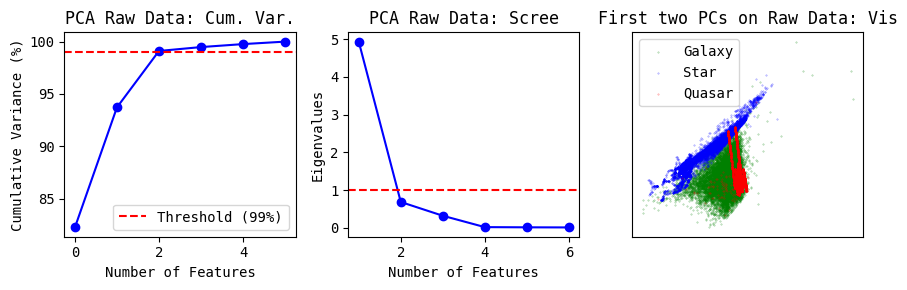

In [ ]:
# Scale both balanced and unbalanced values
data_scaler = StandardScaler().fit(tb_data2)

tbs_data2 = pd.DataFrame(data_scaler.transform(tb_data2), columns=tb_data2.columns)
tbs_label2 = tb_label2.copy()

# Also scale unbalanced, validation and testing with same scaler
ts_data2 = pd.DataFrame(data_scaler.transform(t_data), columns=t_data.columns)
vs_data2 = pd.DataFrame(data_scaler.transform(v_data), columns=v_data.columns)
Ts_data2 = pd.DataFrame(data_scaler.transform(T_data), columns=T_data.columns)

# Run PCA
pca = PCA()
pca.fit(tbs_data2)

fig, axs = plt.subplots(1, 3, figsize=(9,3))
axs = axs.flatten()

# Plot cumulative variance and threshold
threshold_percentage = 99
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
axs[0].plot(cumulative_variance, marker='o', linestyle='-', color='b')
axs[0].axhline(y=threshold_percentage, color='r', linestyle='--', label=f'Threshold ({threshold_percentage}%)')
axs[0].set_title('PCA Raw Data: Cum. Var.')
axs[0].set_xlabel('Number of Features')
axs[0].set_ylabel('Cumulative Variance (%)')
axs[0].legend()

# Scree Plot to determine the number of features based on eigenvalues
eigenvalues = pca.explained_variance_
axs[1].plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='b')
axs[1].axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1')
axs[1].set_title('PCA Raw Data: Scree')
axs[1].set_xlabel('Number of Features')
axs[1].set_ylabel('Eigenvalues')

# Plot PCA visualization
pca = PCA(n_components=6)
tbs_pca_data2 = pd.DataFrame(pca.fit_transform(tbs_data2), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

axs[2].set_title('First two PCs on Raw Data: Vis')

axs[2].scatter(tbs_pca_data2['PC1'][tbs_label2==0], tbs_pca_data2['PC2'][tbs_label2==0], color="green", s=0.1, alpha=0.5, label="Galaxy")
axs[2].scatter(tbs_pca_data2['PC1'][tbs_label2==1], tbs_pca_data2['PC2'][tbs_label2==1], color="blue",  s=0.1, alpha=0.5, label="Star")
axs[2].scatter(tbs_pca_data2['PC1'][tbs_label2==2], tbs_pca_data2['PC2'][tbs_label2==2], color="red",   s=0.1, alpha=0.5, label="Quasar")

# axs[2].set_xlabel('PC1')
# axs[2].set_ylabel('PC2')
axs[2].axes.xaxis.set_visible(False)
axs[2].axes.yaxis.set_visible(False)
axs[2].legend()

fig.tight_layout()
fig.show()

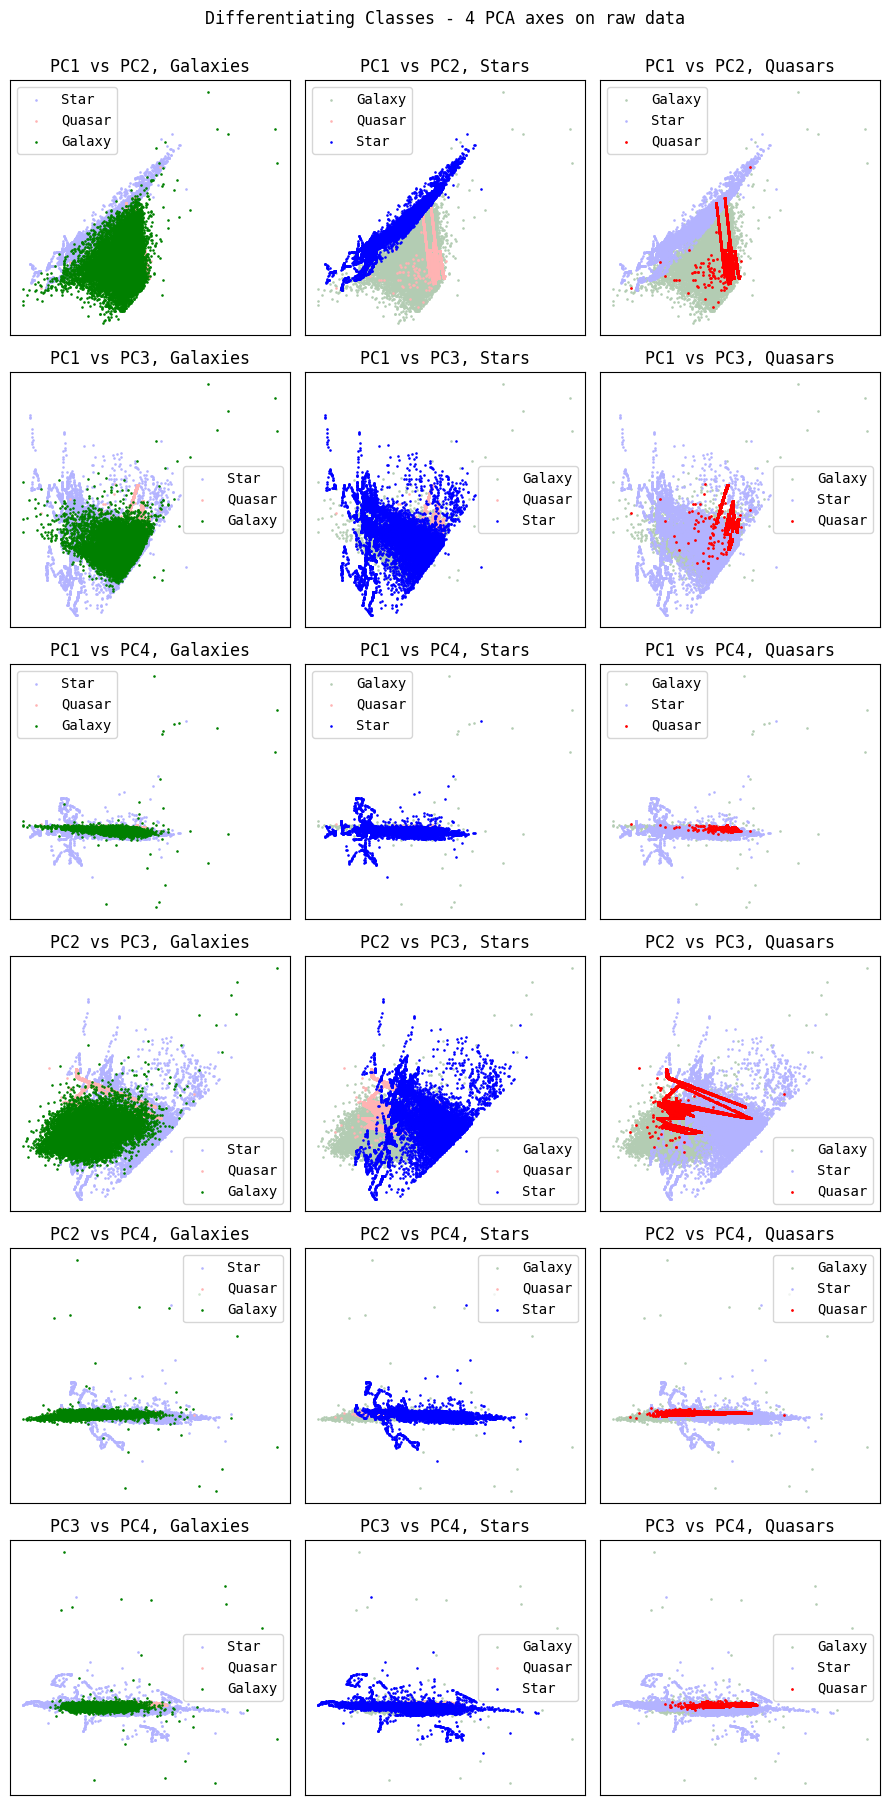

In [ ]:
pcs = "1234"

views     = list(itertools.combinations(pcs, 2))
width     = 3
height    = len(views)
fig, axss = plt.subplots(height, width, figsize=(width*3, height*3))

fig.suptitle("Differentiating Classes - 4 PCA axes on raw data", y=1)

for (p1, p2), axs in zip(views, axss):

  axs[0].set_title(f"PC{p1} vs PC{p2}, Galaxies")
  axs[1].set_title(f"PC{p1} vs PC{p2}, Stars")
  axs[2].set_title(f"PC{p1} vs PC{p2}, Quasars")

  axs[0].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==1], tbs_pca_data2[f'PC{p2}'][tbs_label2==1], color=(.7,.7,1), s=0.75, alpha=1, label="Star")
  axs[0].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==2], tbs_pca_data2[f'PC{p2}'][tbs_label2==2], color=(1,.7,.7), s=0.75, alpha=1, label="Quasar")
  axs[0].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==0], tbs_pca_data2[f'PC{p2}'][tbs_label2==0], color="green",   s=0.75, alpha=1, label="Galaxy")

  axs[1].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==0], tbs_pca_data2[f'PC{p2}'][tbs_label2==0], color=(.7,.8,.7), s=0.75, alpha=1, label="Galaxy")
  axs[1].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==2], tbs_pca_data2[f'PC{p2}'][tbs_label2==2], color=(1,.7,.7),  s=0.75, alpha=1, label="Quasar")
  axs[1].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==1], tbs_pca_data2[f'PC{p2}'][tbs_label2==1], color="blue",     s=0.75, alpha=1, label="Star")

  axs[2].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==0], tbs_pca_data2[f'PC{p2}'][tbs_label2==0], color=(.7,.8,.7), s=0.75, alpha=1, label="Galaxy")
  axs[2].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==1], tbs_pca_data2[f'PC{p2}'][tbs_label2==1], color=(.7,.7,1),  s=0.75, alpha=1, label="Star")
  axs[2].scatter(tbs_pca_data2[f'PC{p1}'][tbs_label2==2], tbs_pca_data2[f'PC{p2}'][tbs_label2==2], color="red",      s=1, alpha=1, label="Quasar")

  for a in axs:
    a.legend()
    a.set_xlabel(f'PC{p1}')
    a.set_ylabel(f'PC{p2}')
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)

  fig.tight_layout()
  fig.show()

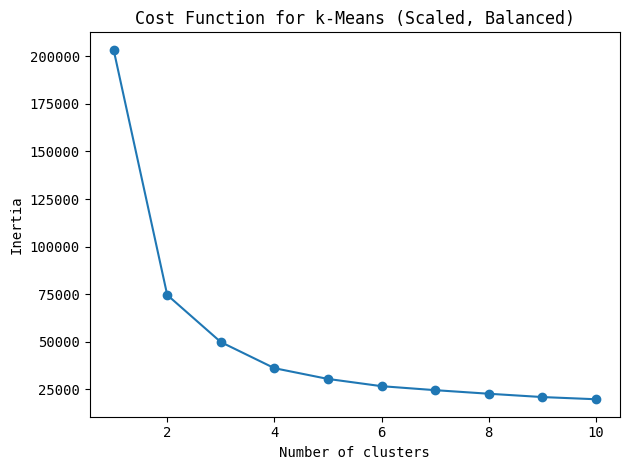

In [ ]:
# Plot the inertia (cost function for k-means) as a function of the number of clusters, k.
# to find the elbow (optimal value for k)
inertia = []
# iterate through candidate values 1-10 for k
for i in range(1, 11):
  km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
  km.fit(tbs_data2)
  inertia.append(km.inertia_)
# plot
plt.plot(range(1, 11), inertia, marker = 'o')
plt.title('Cost Function for k-Means (Scaled, Balanced)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

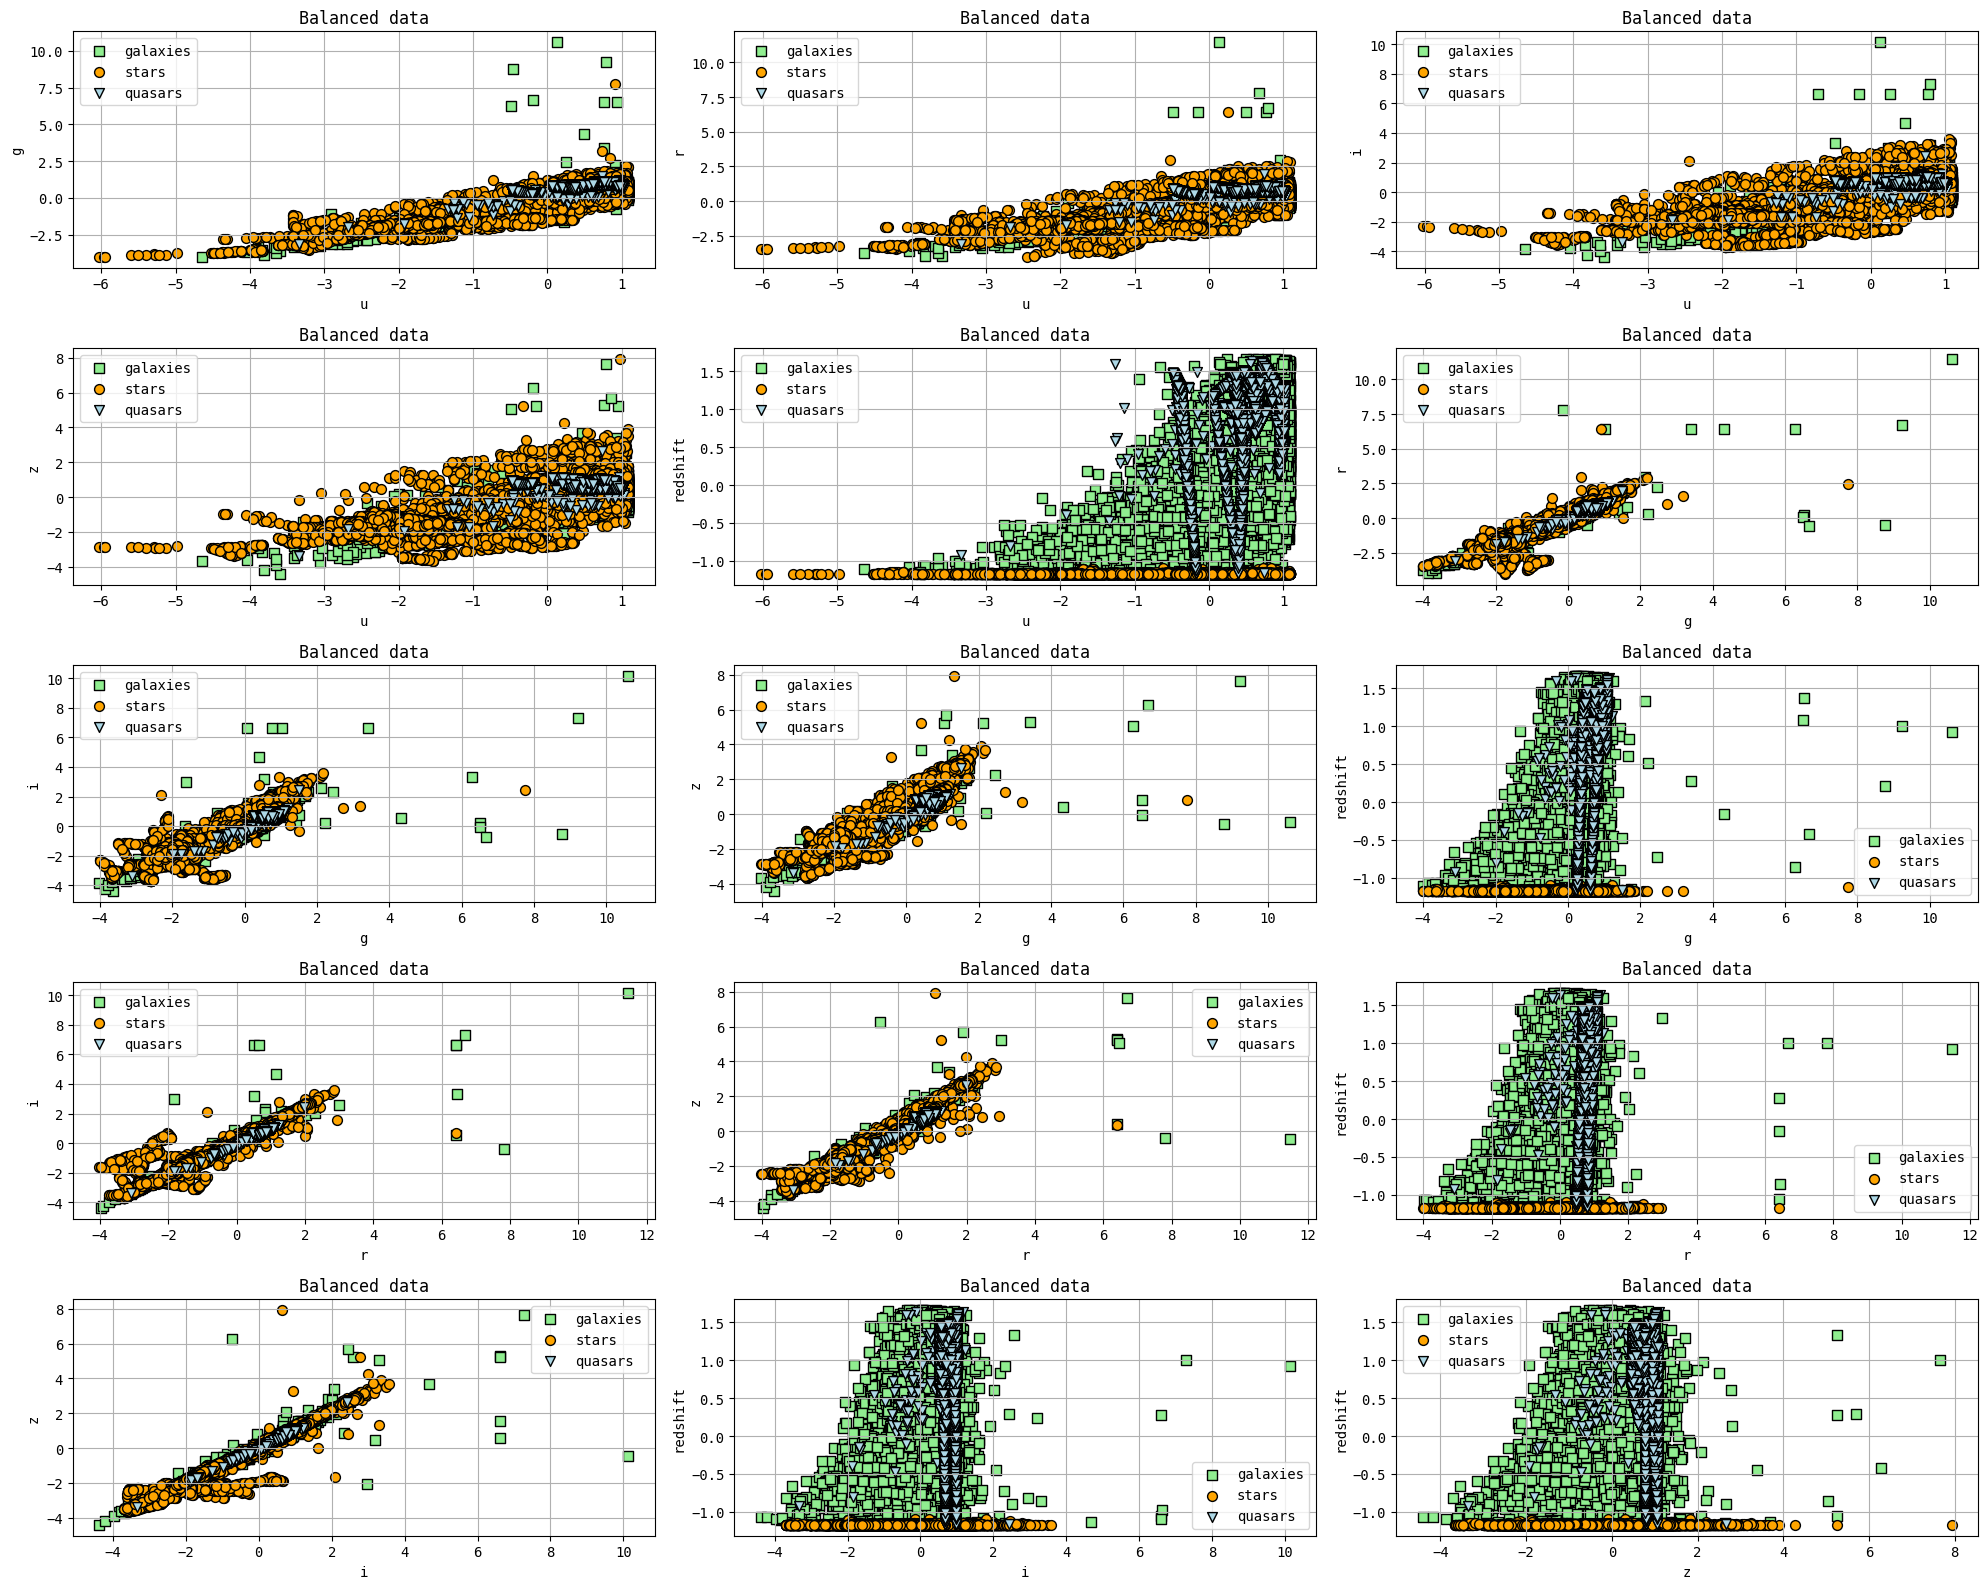

In [ ]:
# plot the 3 clusters for each combinations of two variables

# Create a figure with 15 subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 16))
axes = axes.flatten()

column_names = ['u', 'g', 'r', 'i', 'z', 'redshift']
plots = list(itertools.combinations(column_names, 2))

# Loop through each subplot and plot the data
for i, ax in enumerate(axes):

    a1 = plots[i][0]
    a2 = plots[i][1]

    ax.set_title(f'Subplot {i+1}')


    ax.scatter(
      tbs_data2[tbs_label2==0][a1], tbs_data2[tbs_label2==0][a2],
      s=50, c='lightgreen', marker='s', edgecolor='black',
      label='galaxies')
    ax.scatter(
      tbs_data2[tbs_label2==1][a1], tbs_data2[tbs_label2==1][a2],
      s=50, c='orange', marker='o', edgecolor='black',
      label='stars')
    ax.scatter(
      tbs_data2[tbs_label2==2][a1], tbs_data2[tbs_label2==2][a2],
      s=50, c='lightblue', marker='v', edgecolor='black',
      label='quasars')

    ax.set_title("Balanced data")
    ax.set_xlabel(a1)
    ax.set_ylabel(a2)
    ax.grid()
    ax.legend()

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, random_state=0
)
y = km.fit_predict(tbs_data2)

# plot the 3 clusters for each combinations of two variables

# Create a figure with 15 subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 16))
axes = axes.flatten()

column_names = ['u', 'g', 'r', 'i', 'z', 'redshift']
plots = list(itertools.combinations(column_names, 2))

# Loop through each subplot and plot the data
for i, ax in enumerate(axes):

    a1 = plots[i][0]
    a2 = plots[i][1]

    ax.set_title(f'Subplot {i+1}')


    ax.scatter(
      tbs_data2[y==0][a1], tbs_data2[y==0][a2],
      s=50, c='lightgreen', marker='s', edgecolor='black',
      label='cluster 1')
    ax.scatter(
      tbs_data2[y==1][a1], tbs_data2[y==1][a2],
      s=50, c='orange', marker='o', edgecolor='black',
      label='cluster 2')
    ax.scatter(
      tbs_data2[y==2][a1], tbs_data2[y==2][a2],
      s=50, c='lightblue', marker='v', edgecolor='black',
      label='cluster 3')

    ax.scatter(
      km.cluster_centers_[:, column_names.index(a1)], km.cluster_centers_[:, column_names.index(a2)],
      s=250, marker='*',
      c='red', edgecolor='black',
      label='centroids' )

    ax.set_title("results with k-means")
    ax.set_xlabel(a1)
    ax.set_ylabel(a2)
    ax.grid()
    ax.legend()

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plot
plt.show()


Classification with k-means Algorithm after kMeansSMOTE
Confusion Matrix

 [[3480 2431  560]
 [ 770  453  229]
 [  29   42    6]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.54      0.65      6471
           1       0.15      0.31      0.21      1452
           2       0.01      0.08      0.01        77

    accuracy                           0.49      8000
   macro avg       0.33      0.31      0.29      8000
weighted avg       0.69      0.49      0.56      8000


Accuracy:0.49238



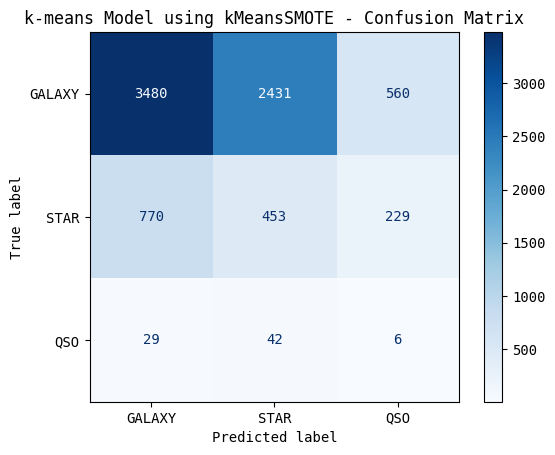

In [ ]:
y_km = km.predict(Ts_data2)
conf_matrix = confusion_matrix(T_label, y_km)

print("Classification with k-means Algorithm after kMeansSMOTE\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, y_km))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, y_km)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("k-means Model using kMeansSMOTE - Confusion Matrix")
plt.show()

# KNN classifier

In [ ]:
perfs = []

for k in range(1, 20):
  model = KNeighborsClassifier(n_neighbors = k).fit(ts_data, t_label)
  training_perf   = model.score(ts_data, t_label)
  validation_perf = model.score(vs_data, v_label)
  testing_perf = model.score(Ts_data, T_label)
  print(f"k={k:2}\t{training_perf:.4f}\t{validation_perf:.4f}\t{testing_perf:.4f}")

k= 1	1.0000	0.9788	0.9761
k= 2	0.9920	0.9772	0.9761
k= 3	0.9871	0.9790	0.9789
k= 4	0.9861	0.9788	0.9790
k= 5	0.9844	0.9778	0.9780
k= 6	0.9837	0.9775	0.9775
k= 7	0.9827	0.9770	0.9769
k= 8	0.9821	0.9762	0.9768
k= 9	0.9815	0.9755	0.9758
k=10	0.9809	0.9752	0.9756
k=11	0.9803	0.9750	0.9744
k=12	0.9799	0.9745	0.9748
k=13	0.9791	0.9740	0.9744
k=14	0.9789	0.9730	0.9742
k=15	0.9783	0.9728	0.9735
k=16	0.9783	0.9722	0.9736
k=17	0.9779	0.9712	0.9728
k=18	0.9778	0.9705	0.9729
k=19	0.9774	0.9708	0.9726


Classification with KNN Algorithm
Confusion Matrix

 [[6368   83   20]
 [  30 1422    0]
 [  57    1   19]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.99      0.98      0.99      6471
           1       0.94      0.98      0.96      1452
           2       0.49      0.25      0.33        77

    accuracy                           0.98      8000
   macro avg       0.81      0.74      0.76      8000
weighted avg       0.97      0.98      0.97      8000


Accuracy:0.97613



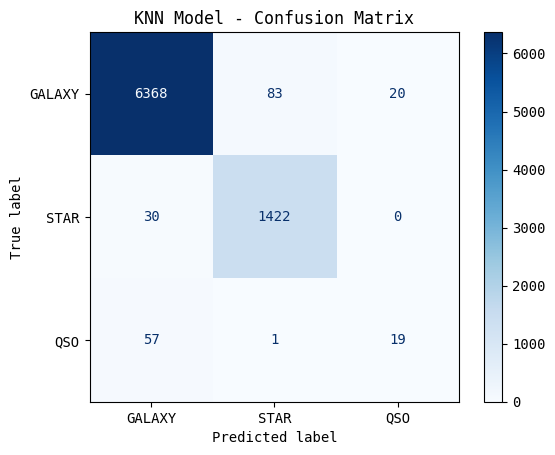

In [ ]:
model = KNeighborsClassifier(n_neighbors = 1).fit(ts_data, t_label)
label_predicted = model.predict(Ts_data)
conf_matrix = confusion_matrix(T_label, label_predicted)

print("Classification with KNN Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, label_predicted))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, label_predicted)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("KNN Model - Confusion Matrix")
plt.show()

In [ ]:
model = KNeighborsClassifier(n_neighbors = 3).fit(ts_data, t_label)

label_predicted = model.predict(Ts_data)
conf_matrix = confusion_matrix(T_label, label_predicted)

print("Classification with K Neighbors Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, label_predicted))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, label_predicted)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("K Neighbors Model - Confusion Matrix")
plt.show()

Classification with K Neighbors Algorithm
Confusion Matrix

 [[6372   95    4]
 [   8 1444    0]
 [  61    1   15]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.99      0.98      0.99      6471
           1       0.94      0.99      0.97      1452
           2       0.79      0.19      0.31        77

    accuracy                           0.98      8000
   macro avg       0.91      0.72      0.75      8000
weighted avg       0.98      0.98      0.98      8000


Accuracy:0.97888



# DTC classifier

Classification with Decision Tree Algorithm
Confusion Matrix

 [[6470    1    0]
 [   0 1452    0]
 [  72    1    4]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6471
           1       1.00      1.00      1.00      1452
           2       1.00      0.05      0.10        77

    accuracy                           0.99      8000
   macro avg       1.00      0.68      0.70      8000
weighted avg       0.99      0.99      0.99      8000


Accuracy:0.99075



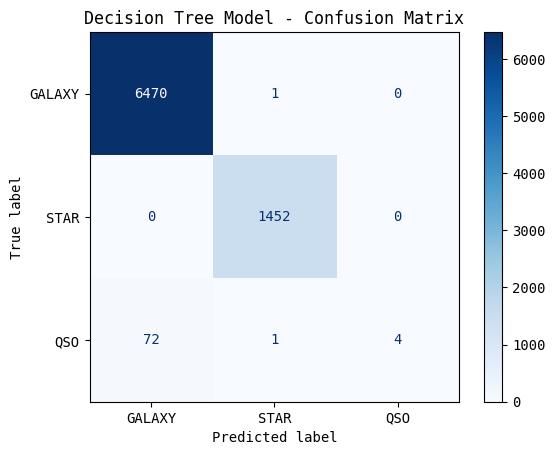

In [ ]:
DTC = DecisionTreeClassifier(max_depth=5).fit(ts_data, t_label)
label_predicted = DTC.predict(Ts_data)
conf_matrix = confusion_matrix(T_label, label_predicted)

print("Classification with Decision Tree Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, label_predicted))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, label_predicted)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("Decision Tree Model - Confusion Matrix")
plt.show()

# Random Forest classifier

Classification with Random Forest Algorithm
Confusion Matrix

 [[6442   28    1]
 [   1 1451    0]
 [  66    1   10]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6471
           1       0.98      1.00      0.99      1452
           2       0.91      0.13      0.23        77

    accuracy                           0.99      8000
   macro avg       0.96      0.71      0.74      8000
weighted avg       0.99      0.99      0.98      8000


Accuracy:0.98787



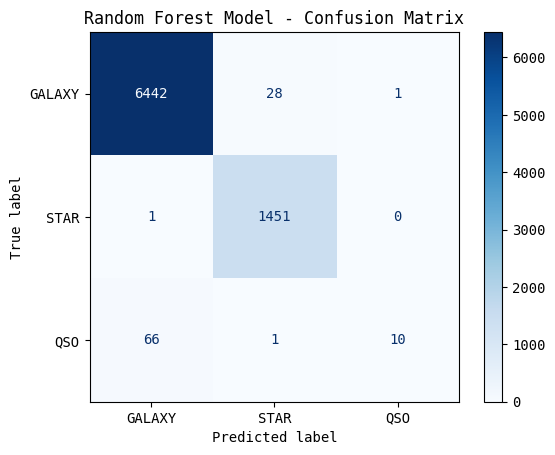

In [ ]:
RFC = RandomForestClassifier(
    max_depth=None, n_estimators=10, max_features=1, random_state=42).fit(ts_data, t_label)
label_predicted = RFC.predict(Ts_data)
conf_matrix = confusion_matrix(T_label, label_predicted)

print("Classification with Random Forest Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, label_predicted))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, label_predicted)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("Random Forest Model - Confusion Matrix")
plt.show()

# SVM classifier

SVM_RBF_UnNorm: 0.1815
SVM_Lin_UnNorm: 0.5125
SVM_RBF_Norm: 0.98075
SVM_Lin_Norm: 0.973875
Classification with SVM RBF Algorithm
Confusion Matrix

 [[6380   89    2]
 [   2 1450    0]
 [  58    3   16]]
Classification Report: 

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6471
           1       0.94      1.00      0.97      1452
           2       0.89      0.21      0.34        77

    accuracy                           0.98      8000
   macro avg       0.94      0.73      0.76      8000
weighted avg       0.98      0.98      0.98      8000


Accuracy:0.98075



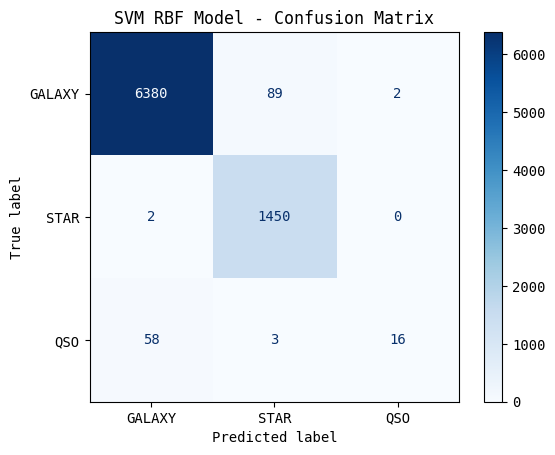

In [ ]:
# Unnormalized
SVM_RBF_Unnorm = SVC(gamma=2, C=1, random_state=42).fit(t_data, t_label)
SVM_Lin_Unnorm = SVC(kernel="linear", C=0.025, random_state=42).fit(t_data, t_label)

print("SVM_RBF_UnNorm:", SVM_RBF_Unnorm.score(Ts_data, T_label))
print("SVM_Lin_UnNorm:", SVM_Lin_Unnorm.score(Ts_data, T_label))

# Normalized
SVM_RBF_Norm = SVC(gamma=2, C=1, random_state=42).fit(ts_data, t_label)
SVM_Lin_Norm = SVC(kernel="linear", C=0.025, random_state=42).fit(ts_data, t_label)

print("SVM_RBF_Norm:", SVM_RBF_Norm.score(Ts_data, T_label))
print("SVM_Lin_Norm:", SVM_Lin_Norm.score(Ts_data, T_label))


# Highest accuracy (98.075) goes to SVM_RBF_Norm
label_predicted = SVM_RBF_Norm.predict(Ts_data)
conf_matrix = confusion_matrix(T_label, label_predicted)

print("Classification with SVM RBF Algorithm\nConfusion Matrix\n\n", conf_matrix)

print('Classification Report: \n\n',classification_report(T_label, label_predicted))
print('\nAccuracy:{0:.5f}\n'.format(accuracy_score(T_label, label_predicted)))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                                 display_labels=["GALAXY", "STAR", "QSO"])

disp.plot(cmap=plt.cm.Blues)

plt.title("SVM RBF Model - Confusion Matrix")
plt.show()

# Below this section is miscellaneous

3.3929950253175023
91.86473064682991


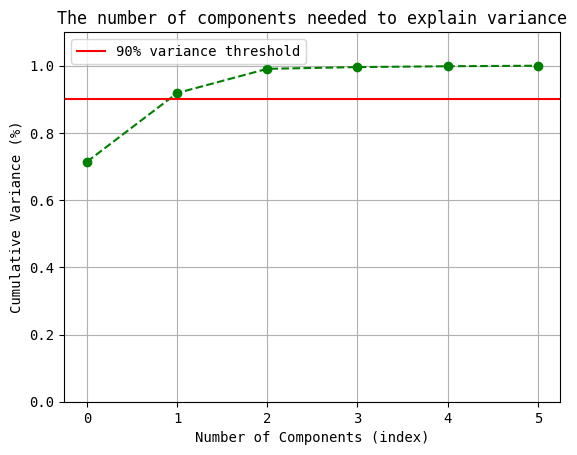

In [ ]:
pca = PCA()
# fit the PCA model to our data
prin_comp = pca.fit_transform(data_scaler.transform(tb_data))

# 2
# determine how many features we should include when performing PCA
components = np.arange(0, 6, step=1)
variance = np.cumsum(pca.explained_variance_ratio_)

print(np.sum(pca.explained_variance_[0:2]))
print(np.sum(pca.explained_variance_ratio_[0:2])*100)

# We wish to recreate the plot from the lecture slides
plt.plot(components, variance, color = 'green', marker = 'o', linestyle = '--')
# 90% variance threshold in lecture slides
plt.axhline(y = 0.9, color = 'red', label = '90% variance threshold')
plt.title('The number of components needed to explain variance')
plt.ylim(0, 1.1)
plt.xlabel('Number of Components (index)')
plt.ylabel('Cumulative Variance (%)')
plt.legend(loc='upper left')
plt.grid()
plt.show()